In [70]:
from __future__ import print_function, division

import pandas as pd
import numpy as np

from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import joblib
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import HTML
from scipy.spatial.distance import pdist, cdist
%pylab inline

from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [71]:
# Add all the data to the Tcams no dups...
#df_tcams_nd = df_tcams.groupby('SMILESIS').mean()
df_tcams_nd = pd.read_pickle('parsed/tcams_nodups.pkl')
full_df = df_tcams_nd.copy()
full_df.rename(columns={'pXC50_3D7' : 'POTENCY'}, inplace=True)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV

model_dict = {'ridge' : {'m': Ridge, 'kw': {'fit_intercept': True, 'alpha': 0.1}},
              'rcv':  {'m': RidgeCV, 'kw': {'cv': 5}},
              'rf': {'m': RandomForestRegressor, 'kw': {'n_estimators': 100, 'n_jobs': 4, 'max_depth': 10}}}

method = 'rf'
mdl = model_dict[method]['m'](**model_dict[method]['kw'])

full_df.dropna(subset=['POTENCY'], inplace=True)
fpa = np.asarray([x for x in full_df.fps.values])

In [72]:
all_dists[:20]

array([ 0.48076923,  0.45283019,  0.44827586,  0.56097561,  0.54166667,
        0.515625  ,  0.45098039,  0.54545455,  0.51923077,  0.48214286,
        0.47142857,  0.45901639,  0.54545455,  0.4       ,  0.45833333,
        0.58333333,  0.51785714,  0.51666667,  0.42553191,  0.52542373])

In [73]:
all_dists[:-20]

array([ 0.48076923,  0.45283019,  0.44827586, ...,  0.53333333,
        0.52727273,  0.53225806])

In [74]:
all_dists[:20]

array([ 0.48076923,  0.45283019,  0.44827586,  0.56097561,  0.54166667,
        0.515625  ,  0.45098039,  0.54545455,  0.51923077,  0.48214286,
        0.47142857,  0.45901639,  0.54545455,  0.4       ,  0.45833333,
        0.58333333,  0.51785714,  0.51666667,  0.42553191,  0.52542373])

In [75]:
all_distsN[:20]

array([ 0.48076923,  0.45283019,  0.44827586,  0.56097561,  0.54166667,
        0.515625  ,  0.45098039,  0.54545455,  0.51923077,  0.48214286,
        0.47142857,  0.45901639,  0.54545455,  0.4       ,  0.45833333,
        0.58333333,  0.51785714,  0.51666667,  0.42553191,  0.52542373])

In [76]:
%%time
std_files = ['/Users/oliverwatson/evartech/molport/standardn_' + str(i) for i in range(15)]

df0 = pd.read_pickle(std_files[0])

N = df0.shape[0] 
i = 0

redo = True

if redo:
    all_dists = np.asarray([])

    while (i < N - 1):
        idcs = np.arange(i, min(N, i+10000))
        fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
        blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)
        all_dists = np.concatenate((all_dists, blk_dists))
        i += 10000
        pass
    np.save('all_dists.npy', all_dists)

all_dists = np.load('all_dists.npy')

CPU times: user 17min 14s, sys: 32.2 s, total: 17min 47s
Wall time: 21min 32s


In [77]:
assert(std_files[0] == '/Users/oliverwatson/evartech/molport/standardn_0')

In [78]:
%%time

df0 = pd.read_pickle(std_files[0])

N = df0.shape[0]
i = 0
n_2 = int(fpa.shape[0]/2)
redo = True

if redo:
    all_distsN = np.asarray([])
    all_distsN2 = np.asarray([])
    
    while (i < N - 1):
        idcs = np.arange(i, min(N, i+10000))
        idcs2 = np.random.choice(fpa.shape[0], n_2, replace=False)
        fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
        blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)
        blk_dists2 = nanmin(cdist(fpr, fpa[idcs2], metric='jaccard'),axis=1)
        all_distsN = np.concatenate((all_distsN, blk_dists))
        all_distsN2 = np.concatenate((all_distsN2, blk_dists2))
        i += 10000
        pass
    np.save('all_distsN.npy', all_distsN)
    np.save('all_distsN2.npy', all_distsN2)
    pass

all_distsN = np.load('all_distsN.npy')
all_distsN2 = np.load('all_distsN2.npy')

CPU times: user 24min 26s, sys: 40.5 s, total: 25min 6s
Wall time: 25min 31s


In [79]:
figsize(20, 10)

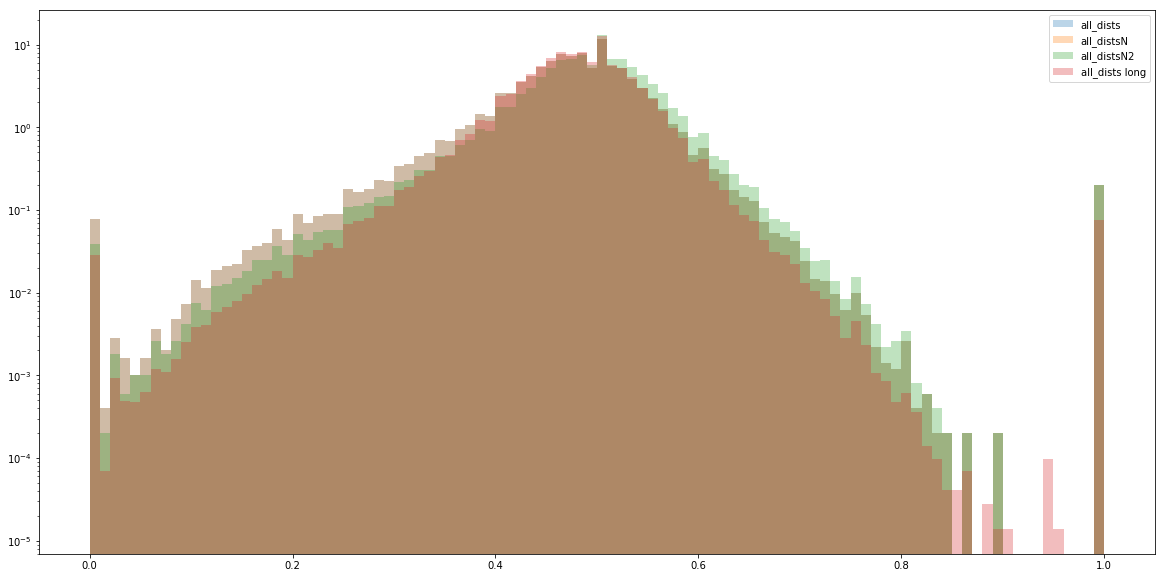

In [80]:
_ = plt.hist(all_dists, bins=100, label='all_dists', alpha=0.3, density=True)
_ = plt.hist(all_distsN, bins=100, label='all_distsN', alpha=0.3, density=True)
_ = plt.hist(all_distsN2, bins=100, label='all_distsN2', alpha=0.3, density=True)
_ = plt.hist(all_dists_long, bins=100, label='all_dists long', alpha=0.3, density=True)
_ = plt.yscale('log')
_ = legend(loc='best')

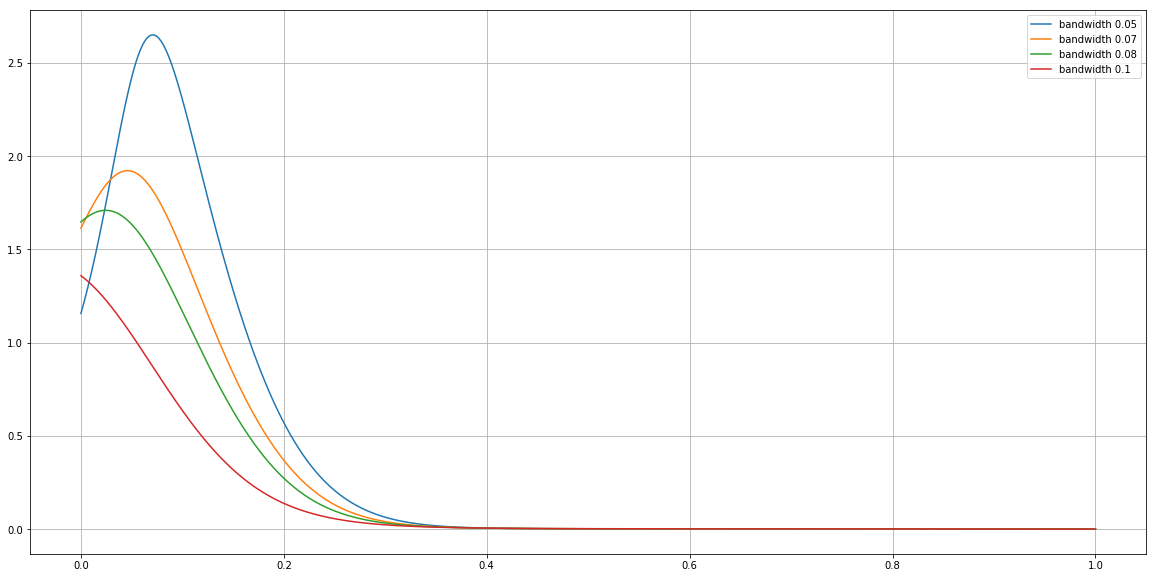

In [81]:
for bandwith in [0.05, 0.07, 0.08, 0.1]:
    X = all_distsN2[~np.isnan(all_distsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith))
grid(True)
legend(loc='best')
savefig('bandwidth.png')

In [82]:
all_dists_long = np.load('all_dists_long.npy')

CPU times: user 58min 57s, sys: 5.84 s, total: 59min 3s
Wall time: 59min 18s


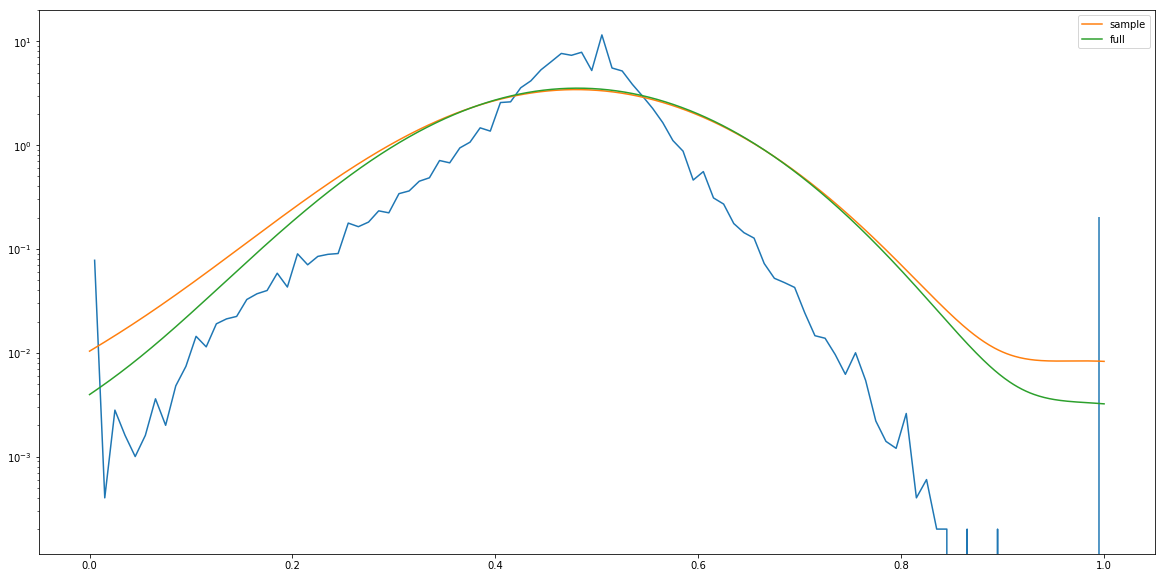

In [83]:
%%time
from sklearn.neighbors import KernelDensity
X_plot = np.linspace(0, 1, 1000)[:, np.newaxis]
X = all_dists[~np.isnan(all_dists)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_densRA = kde.score_samples(X_plot)
X = all_dists_long[~np.isnan(all_dists_long)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_densRAf = kde.score_samples(X_plot)
mra_hist = np.histogram(all_dists[~np.isnan(all_dists)], density=True, bins=100)
x_axis = 0.5*(mra_hist[1][1:] + mra_hist[1][:-1])
plt.plot(x_axis, mra_hist[0])
plt.plot(X_plot[:,0], np.exp(log_densRA), label='sample')
plt.plot(X_plot[:,0], np.exp(log_densRAf), label='full')
_ = plt.yscale('log')
legend(loc='best')

In [84]:
n_2 = int(fpa.shape[0]/2)
tries = 5
redo = True
if redo:
    all_AdistsN2 = np.asarray([])
    
    for i in range(tries):
        idcs2 = np.random.choice(fpa.shape[0], n_2, replace=False)
        idcs1 = np.delete(np.arange(fpa.shape[0]), idcs2)
        blk_dists2 = nanmin(cdist(fpa[idcs1], fpa[idcs2], metric='jaccard'),axis=1)
        blk_dists2p = nanmin(cdist(fpa[idcs2], fpa[idcs1], metric='jaccard'),axis=1)
        all_AdistsN2 = np.concatenate((blk_dists2, blk_dists2p, all_AdistsN2))
        #all_AdistsN2 = np.concatenate((blk_dists2, all_AdistsN2))
        pass
    np.save('all_AdistsN2_sc.npy', all_AdistsN2)
    pass
all_AdistsN2 = np.load('all_AdistsN2_sc.npy')

In [85]:
all_AdistsN2_full = np.load('all_AdistsN2.npy')

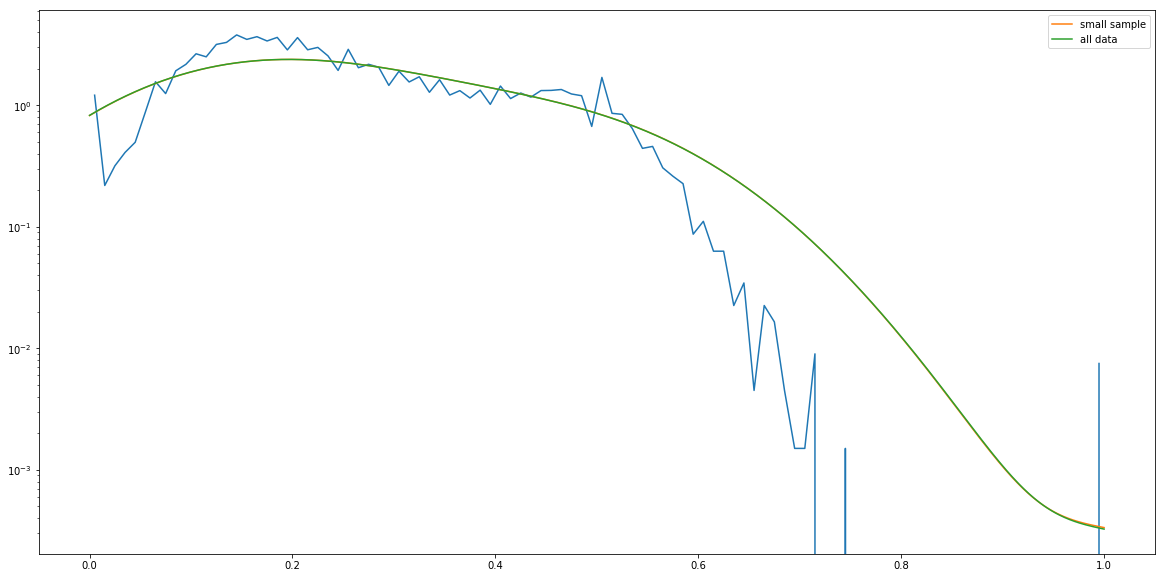

In [86]:
# Doing the correct way (2-way)
mra_hist = np.histogram(all_AdistsN2[~np.isnan(all_AdistsN2)], density=True, bins=100)
X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_densAA = kde.score_samples(X_plot)
X = all_AdistsN2_full[~np.isnan(all_AdistsN2_full)][:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_densAAf = kde.score_samples(X_plot)
x_axis = 0.5*(mra_hist[1][1:] + mra_hist[1][:-1])
plt.plot(x_axis, mra_hist[0])
plt.plot(X_plot[:,0], np.exp(log_densAA), label='small sample')
plt.plot(X_plot[:,0], np.exp(log_densAAf), label='all data')
_ = plt.yscale('log')
legend(loc='best')

In [87]:
all_dists.shape

(499939,)

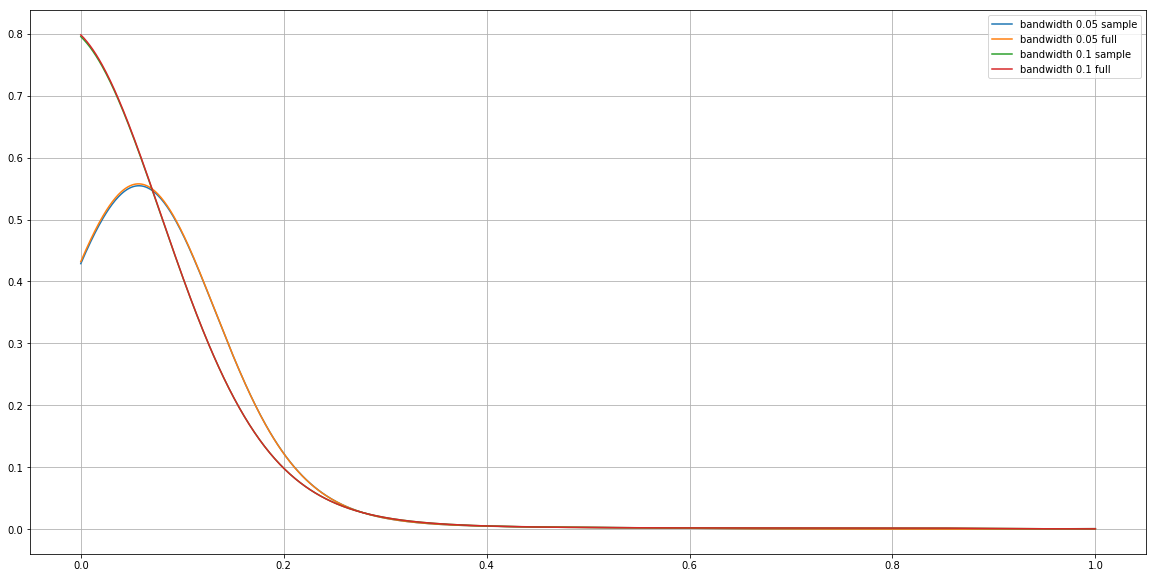

In [88]:
fa = 0.01
for bandwith in [0.05, 0.1]:
    X = all_dists[~np.isnan(all_dists)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densrA = kde.score_samples(X_plot)
    X = all_AdistsN2_full[~np.isnan(all_AdistsN2_full)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAAf = kde.score_samples(X_plot)  
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
    plt.plot(X_plot[:,0], fa * np.exp(log_densAAf - log_densRA), label='bandwidth ' + str(bandwith) + ' full')
grid(True)
legend(loc='best')

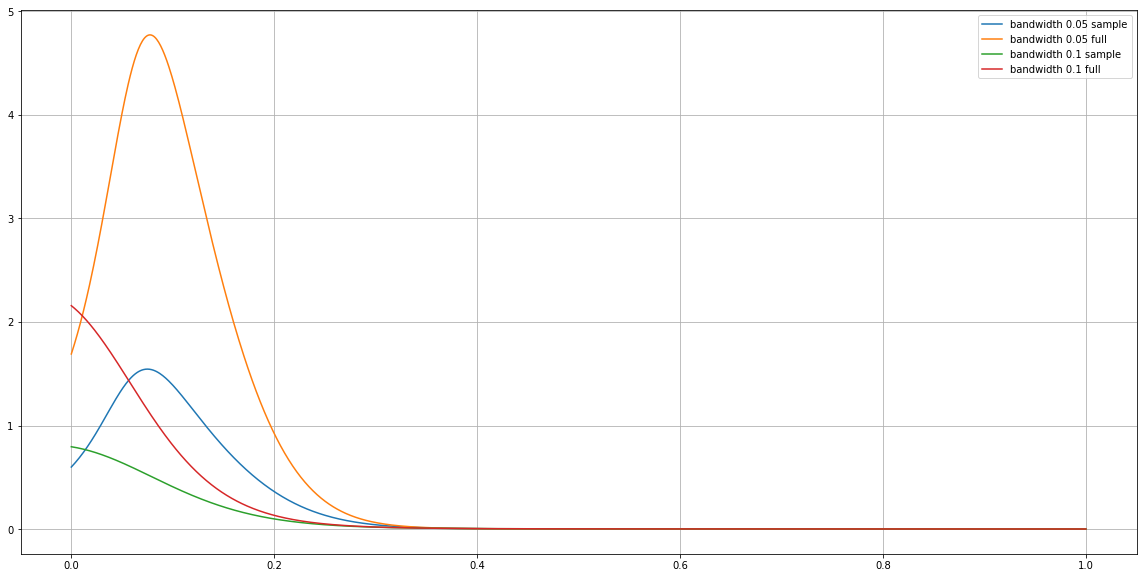

In [89]:
fa = 0.01
for bandwith in [0.05, 0.1]:
    X = all_dists[~np.isnan(all_dists)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_dists_long[~np.isnan(all_dists_long)][500000:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRAf = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRAf), label='bandwidth ' + str(bandwith) + ' full')
grid(True)
legend(loc='best')

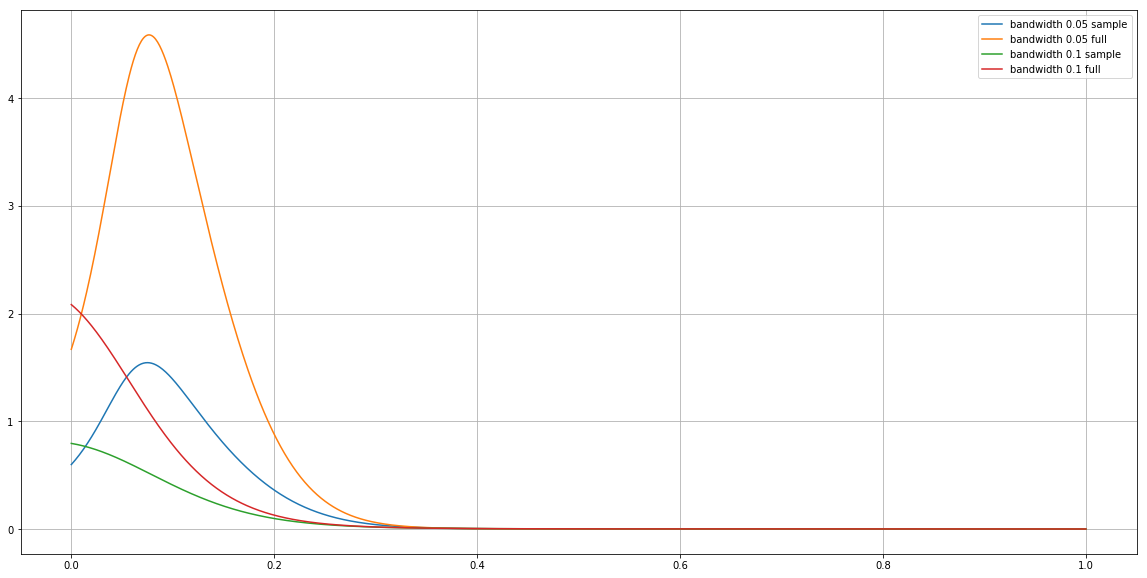

In [90]:
fa = 0.01
for bandwith in [0.05, 0.1]:
    X = all_dists[~np.isnan(all_dists)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_dists_long[~np.isnan(all_dists_long)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRAf = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRAf), label='bandwidth ' + str(bandwith) + ' full')
grid(True)
legend(loc='best')

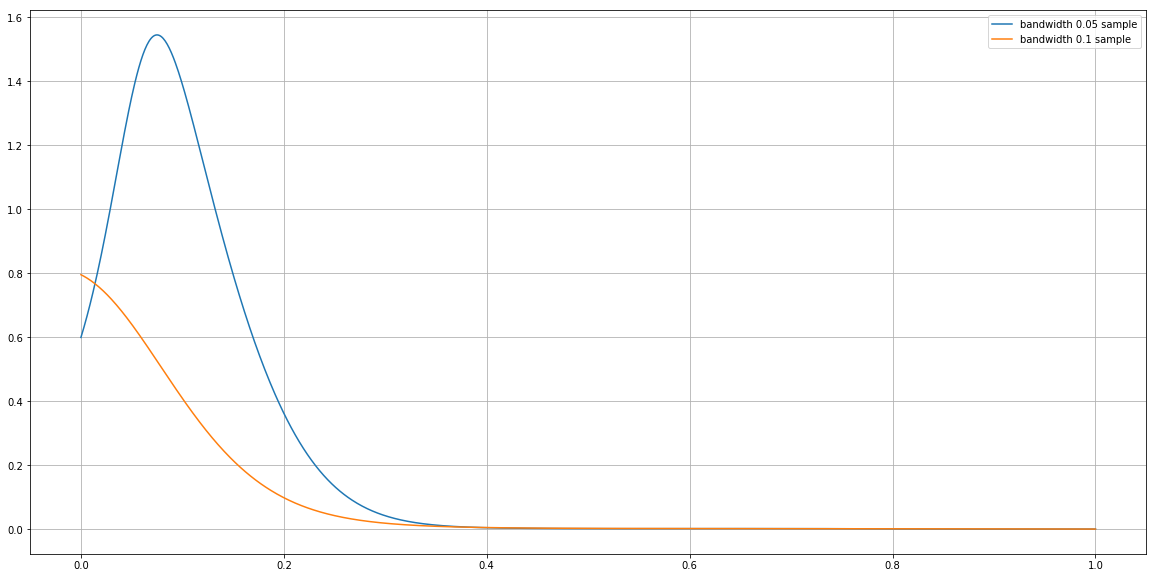

In [91]:
fa = 0.01
for bandwith in [0.05, 0.1]:
    X = all_dists[~np.isnan(all_dists)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

In [92]:
all_dists[-20:]

array([ 0.44444444,  0.36363636,  0.45454545,  0.45652174,  0.38636364,
        0.49056604,  0.45454545,  0.44186047,  0.46511628,  0.46938776,
        0.34146341,  0.40816327,  0.42222222,  0.42553191,  0.32432432,
        0.41666667,  0.41860465,  0.43902439,  0.46808511,  0.39130435])

In [93]:
all_dists_long[-20:]

array([ 0.53703704,  0.5       ,  0.52631579,  0.5       ,  0.59016393,
        0.52631579,  0.44444444,  0.49019608,  0.42592593,  0.60377358,
        0.44642857,  0.49180328,  0.50943396,  0.51612903,  0.44642857,
        0.5       ,  0.5       ,  0.47169811,  0.38461538,  0.48333333])

In [94]:
%%time
redo = True

if redo:
    for (j, fn) in enumerate(std_files):
        print('Doing', j)
        all_dists_long_i = np.asarray([])
        df0 = pd.read_pickle(fn)
        N = df0.shape[0]
        i = 0
        while (i < N - 1):
            idcs = np.arange(i, min(N, i+10000))
            fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
            blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=1)
            all_dists_long_i = np.concatenate((all_dists_long_i, blk_dists))
            i += 10000
            pass
        
        np.save('all_dists_long_' + str(j) + '.npy', all_dists_long_i)

Doing 0
Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
Doing 10
Doing 11
Doing 12
Doing 13
Doing 14
CPU times: user 3h 49min 8s, sys: 4min 8s, total: 3h 53min 17s
Wall time: 3h 53min 23s


CPU times: user 2min 17s, sys: 261 ms, total: 2min 17s
Wall time: 2min 17s


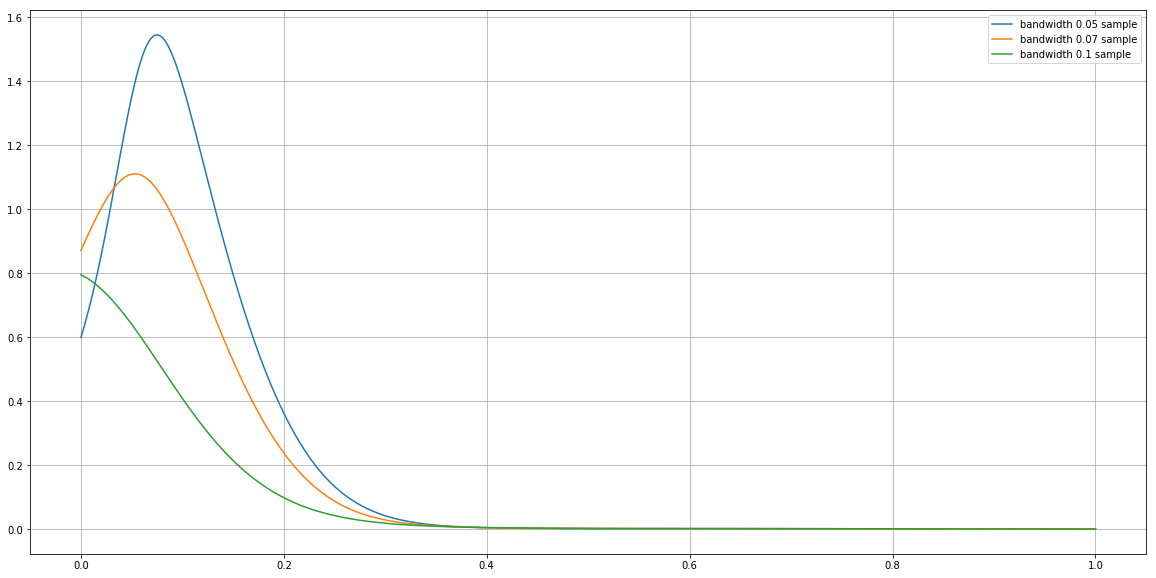

In [97]:
%%time
i = 0
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 2min 8s, sys: 150 ms, total: 2min 9s
Wall time: 2min 9s


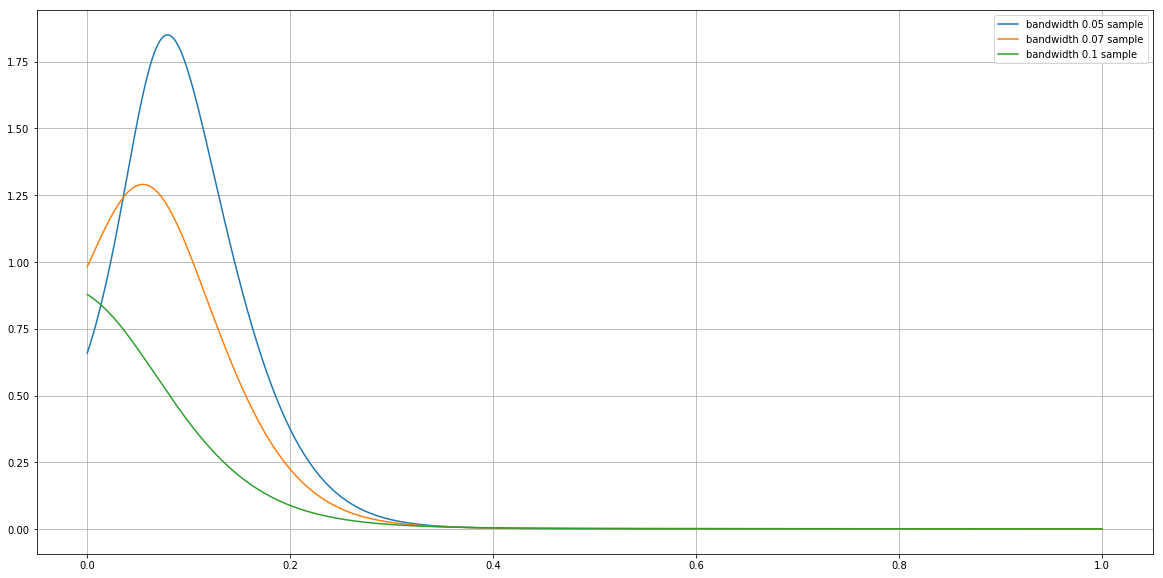

In [98]:
%%time
i = 1
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 2min 8s, sys: 156 ms, total: 2min 8s
Wall time: 2min 8s


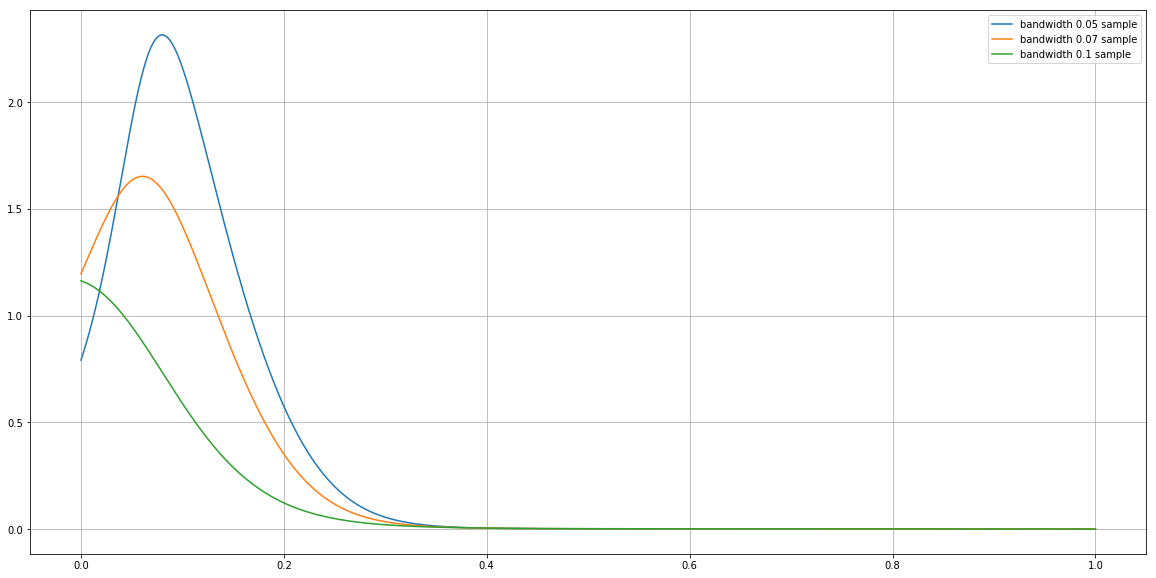

In [99]:
%%time
i = 2
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 2min 26s, sys: 1.06 s, total: 2min 27s
Wall time: 2min 30s


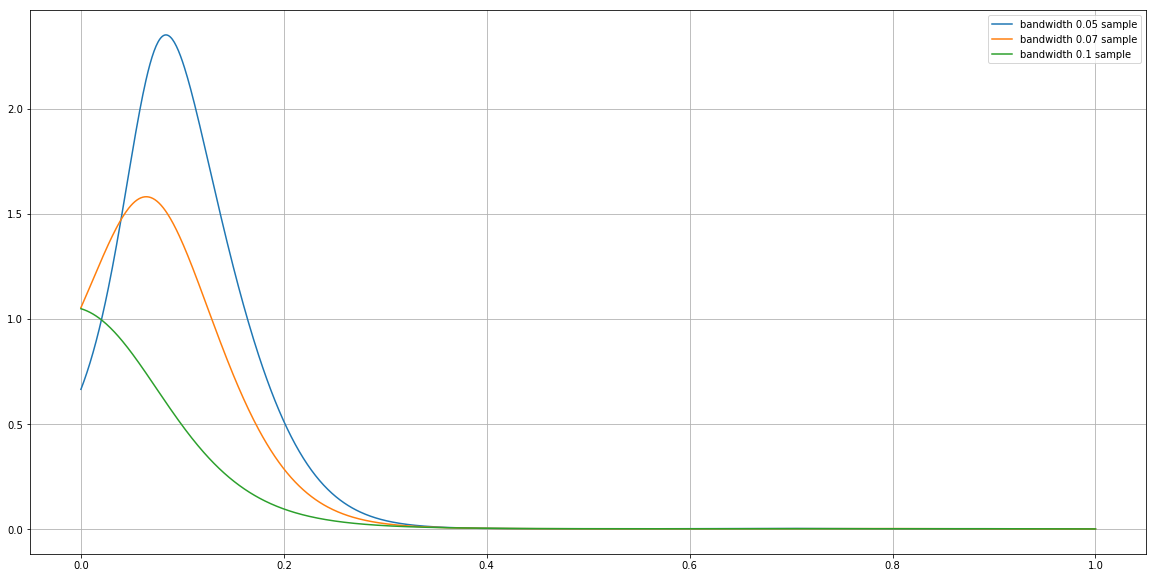

In [100]:
%%time
i = 3
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 2min 57s, sys: 2.15 s, total: 2min 59s
Wall time: 3min 2s


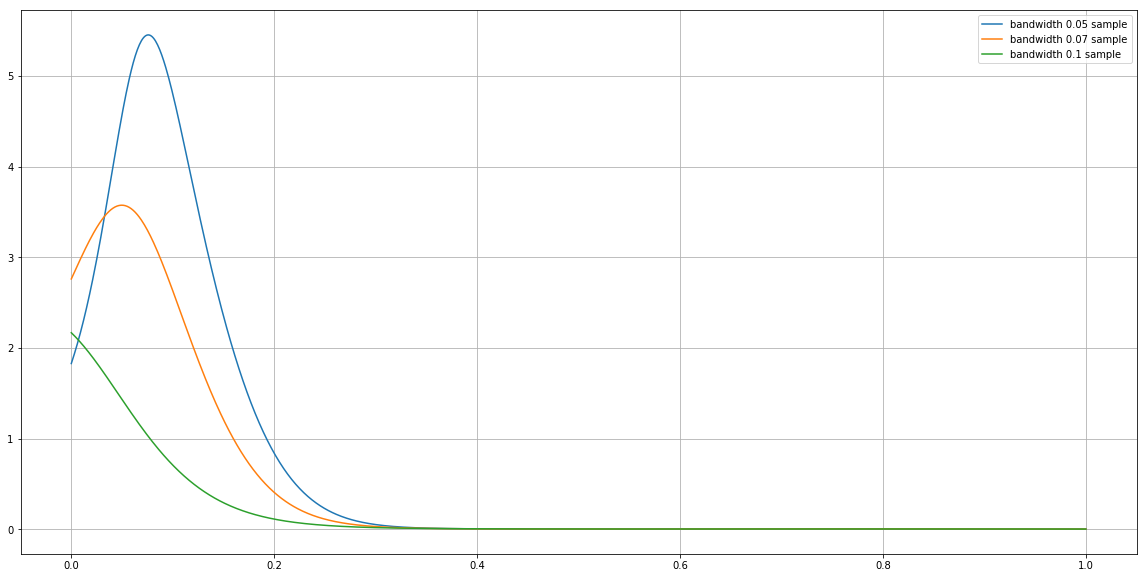

In [101]:
%%time
i = 4
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 2min 50s, sys: 2.05 s, total: 2min 52s
Wall time: 2min 54s


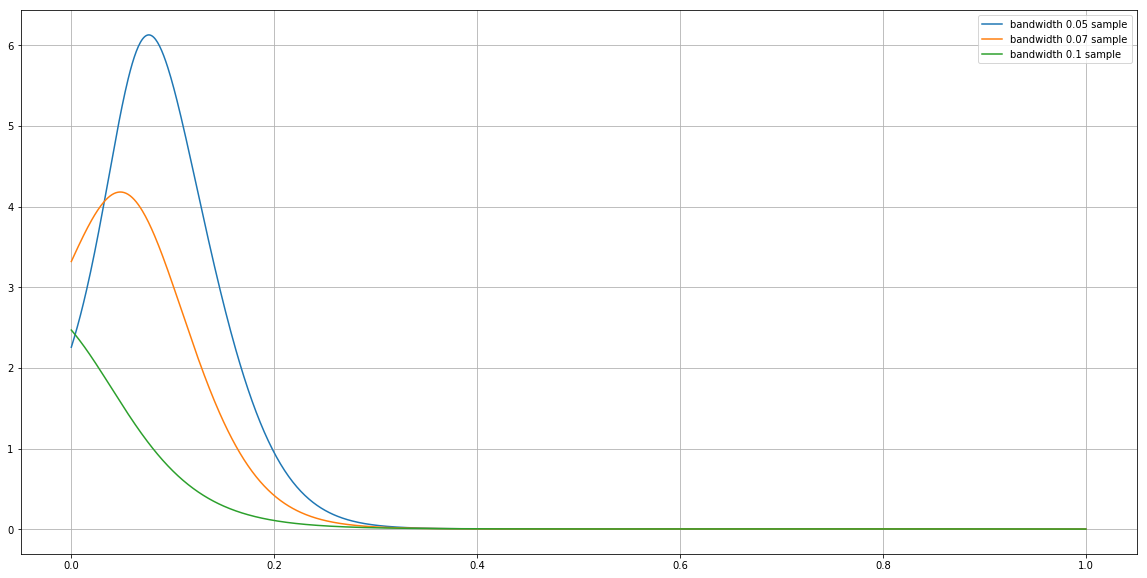

In [102]:
%%time
i = 5
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 2min 45s, sys: 1.98 s, total: 2min 47s
Wall time: 2min 49s


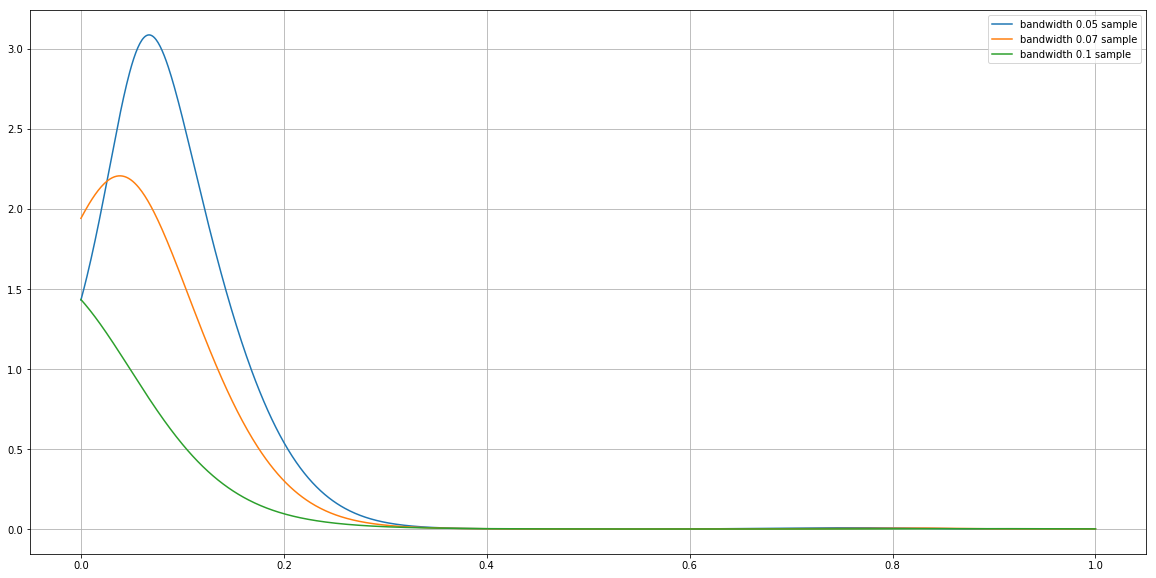

In [103]:
%%time
i = 6
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 3min 1s, sys: 2.38 s, total: 3min 3s
Wall time: 3min 12s


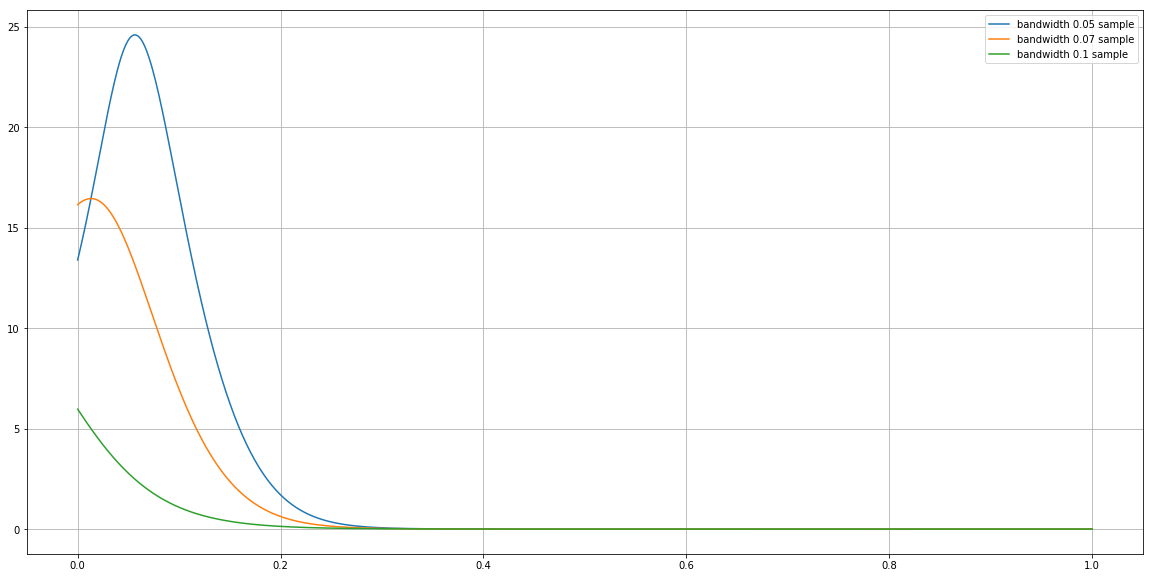

In [104]:
%%time
i = 7
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 2min 50s, sys: 2.21 s, total: 2min 53s
Wall time: 3min 4s


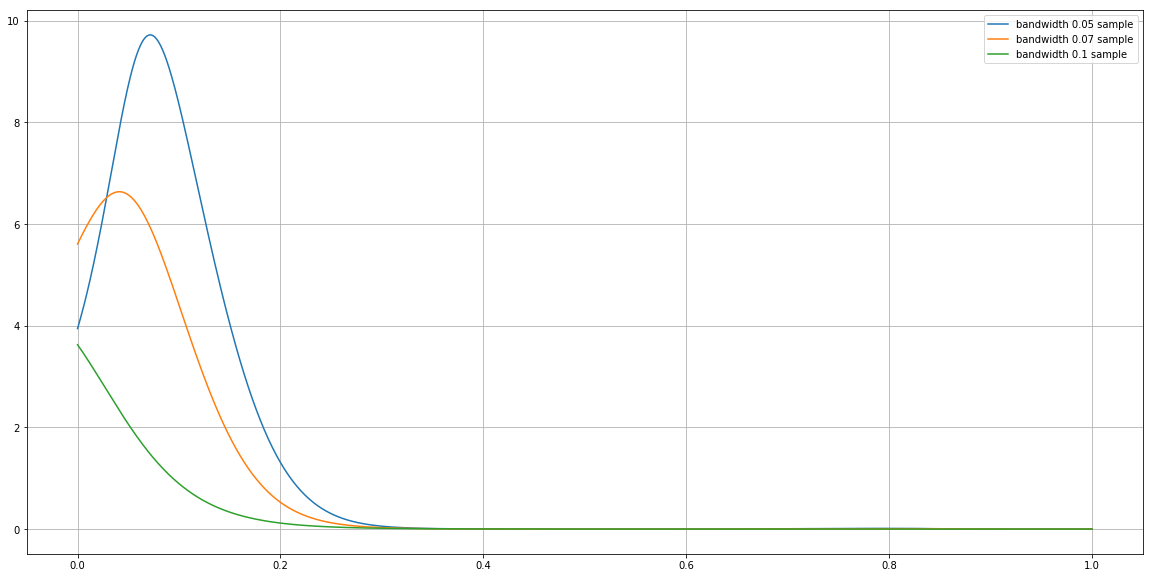

In [105]:
%%time
i = 8
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 2min 57s, sys: 2.38 s, total: 2min 59s
Wall time: 3min 15s


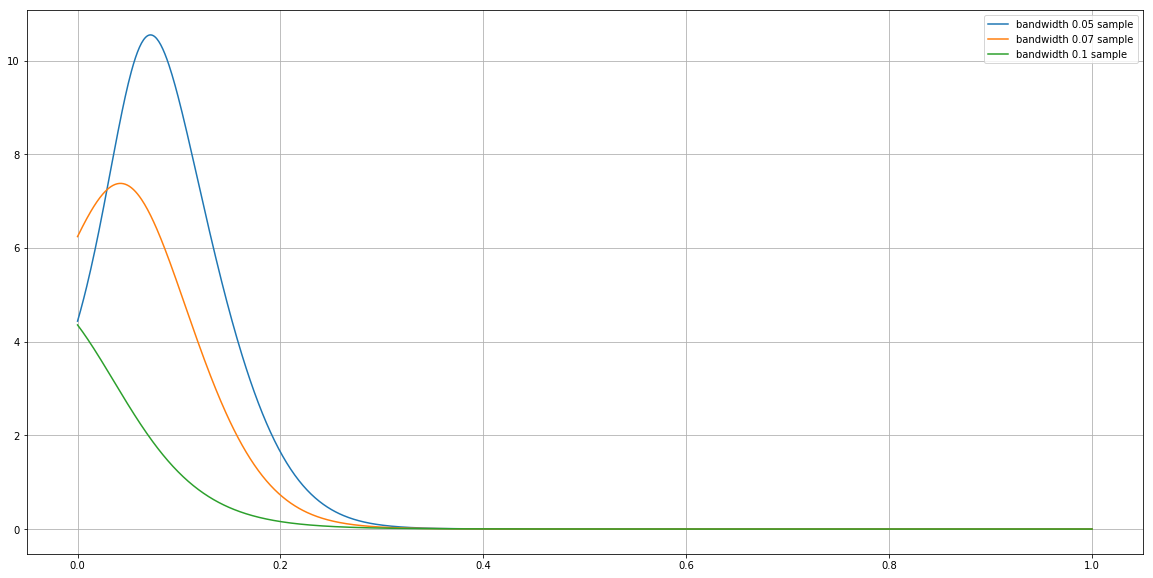

In [106]:
%%time
i = 9
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 2min 59s, sys: 2.31 s, total: 3min 1s
Wall time: 3min 13s


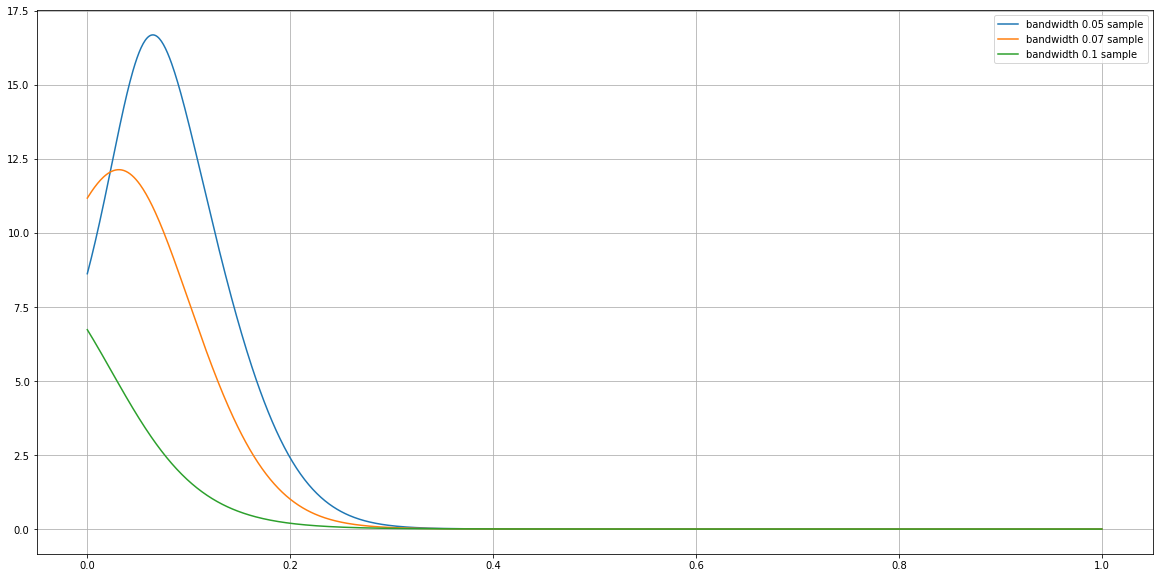

In [107]:
%%time
i = 10
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 3min, sys: 4.44 s, total: 3min 4s
Wall time: 3min 18s


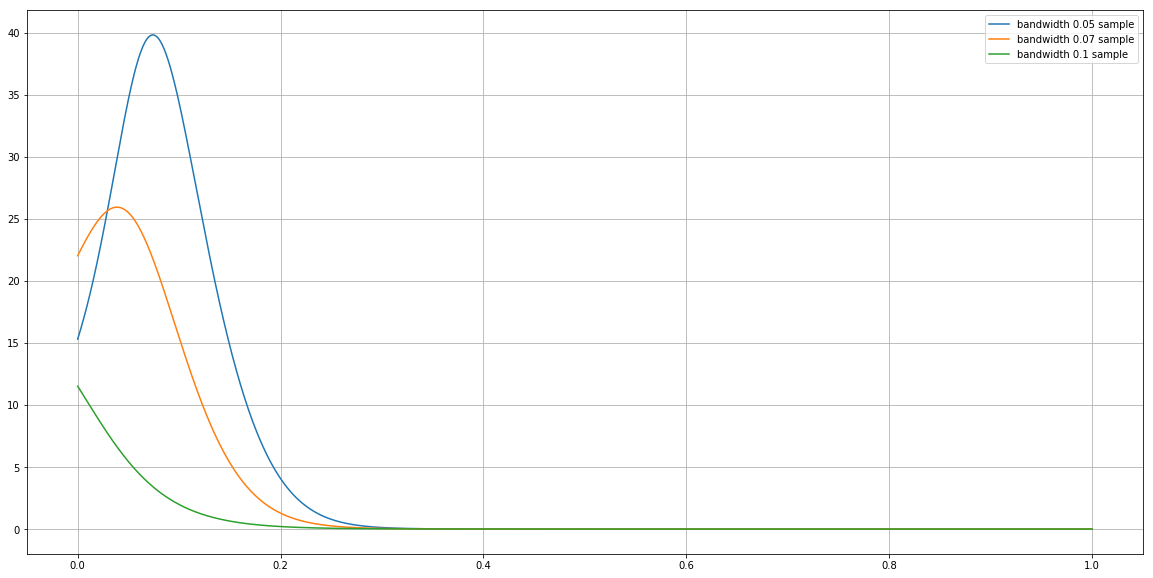

In [108]:
%%time
i = 11
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 3min 1s, sys: 2.38 s, total: 3min 4s
Wall time: 3min 13s


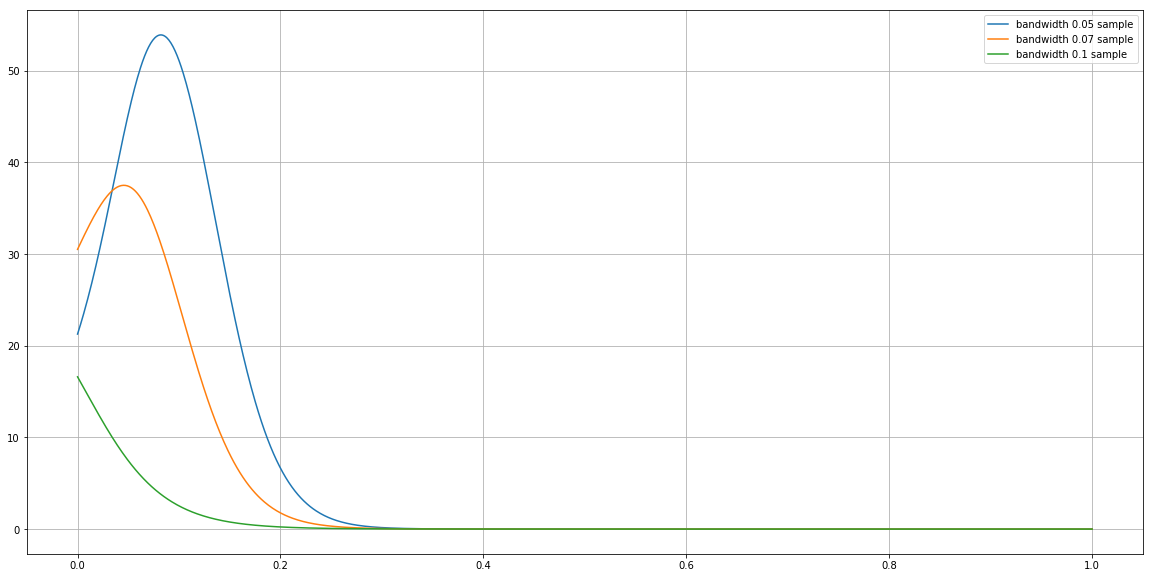

In [109]:
%%time
i = 12
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 2min 58s, sys: 2.35 s, total: 3min 1s
Wall time: 3min 11s


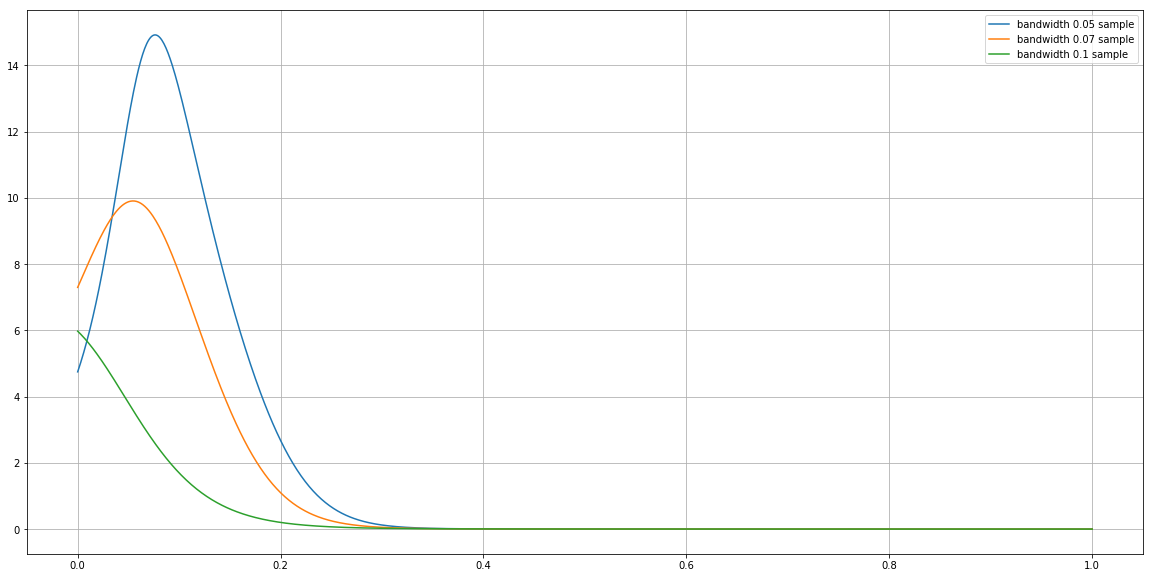

In [110]:
%%time
i = 13
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

CPU times: user 1min 16s, sys: 1 s, total: 1min 17s
Wall time: 1min 22s


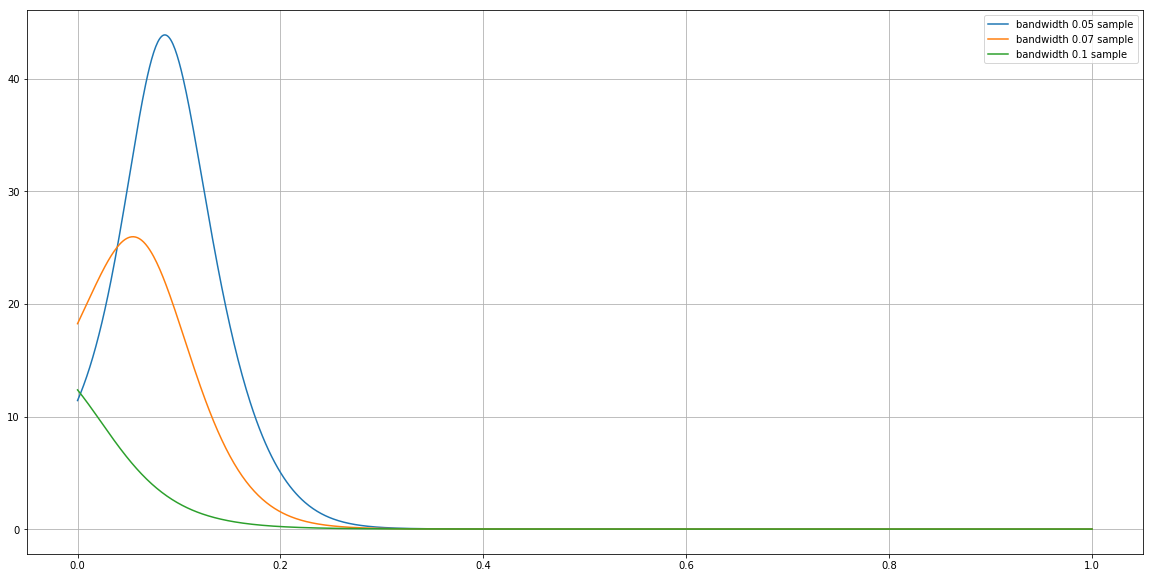

In [111]:
%%time
i = 14
ad = np.load('all_dists_long_' + str(i) + '.npy')
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = ad[~np.isnan(ad)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

In [112]:
ad = np.load('all_dists_long_0.npy')

In [113]:
len(ad[~np.isnan(ad)])

499939

In [114]:
len(ad)

499939

In [115]:
np.sum(ad == 0)

389

In [116]:
np.sum(ad < 0.1)

515

In [117]:
np.sum(ad <  0.3)

9028

In [124]:
for i in range(15):
    ad = np.load('all_dists_long_' + str(i) + '.npy')
    print("File %2d - zero distance : %5d, distance < 0.1 : %5d  distance < 0.3 : %5d, points %d" % 
          (i, np.sum(ad == 0), np.sum(ad < 0.1), np.sum(ad < 0.3), len(ad)))

File  0 - zero distance :   389, distance < 0.1 :   515  distance < 0.3 :  9028, points 499939
File  1 - zero distance :   352, distance < 0.1 :   487  distance < 0.3 :  8870, points 499944
File  2 - zero distance :   305, distance < 0.1 :   401  distance < 0.3 :  5728, points 499824
File  3 - zero distance :   362, distance < 0.1 :   448  distance < 0.3 :  6509, points 499026
File  4 - zero distance :   133, distance < 0.1 :   166  distance < 0.3 :  3881, points 499396
File  5 - zero distance :   105, distance < 0.1 :   137  distance < 0.3 :  3446, points 499308
File  6 - zero distance :   157, distance < 0.1 :   221  distance < 0.3 :  5920, points 498290
File  7 - zero distance :    17, distance < 0.1 :    22  distance < 0.3 :  1825, points 499183
File  8 - zero distance :    58, distance < 0.1 :    78  distance < 0.3 :  2427, points 496725
File  9 - zero distance :    52, distance < 0.1 :    71  distance < 0.3 :  1988, points 499829
File 10 - zero distance :    25, distance < 0.1 : 

In [125]:
all_dists_good = np.concatenate([np.load('all_dists_long_' + str(i) + '.npy') for i in range(7)])

In [126]:
all_dists_good.shape

(3495727,)

In [127]:
np.isnan(all_dists_good).any()

False

CPU times: user 38min 13s, sys: 5.63 s, total: 38min 18s
Wall time: 38min 33s


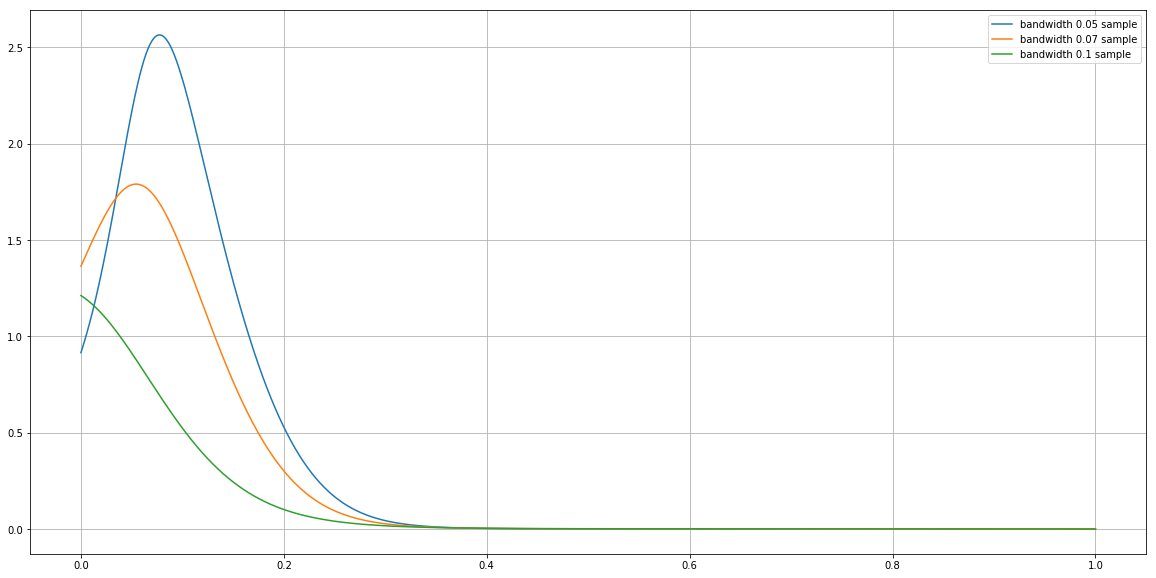

In [128]:
%%time
fa = 0.01
for bandwith in [0.05, 0.07, 0.1]:
    X = all_dists_good[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')

### Stuff to do next...

- How many compounds are not in the MolPort database at all?  Plot some.

- try doing a random properly-weighted sample from the full distribution - see if that gives the correct result

- Plot random compounds from each file - see if you spot a pattern.

In [158]:
redo = False

if redo:
    all_dists_toMP = np.ones(fpa.shape[0])

    for fn in std_files:
        df0 = pd.read_pickle(fn)
        N = df0.shape[0]
        i = 0
        while (i < N - 1):
            idcs = np.arange(i, min(N, i+10000))
            fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
            blk_dists = nanmin(cdist(fpr, fpa, metric='jaccard'),axis=0)
            all_dists_toMP = np.minimum(blk_dists, all_dists_toMP)
            i += 10000
            pass
    np.save('all_dists_toMP.npy', all_dists_toMP)
else:
    all_dists_toMP = np.load('all_dists_toMP.npy')

In [142]:
figsize(10, 20)

In [139]:
def plot_random(i):
    df0 = pd.read_pickle(std_files[i])
    
    idcs = np.random.choice(df0.shape[0], 12)
    fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in df0.iloc[idcs].SMILES.values])
    plt.imshow(fig)

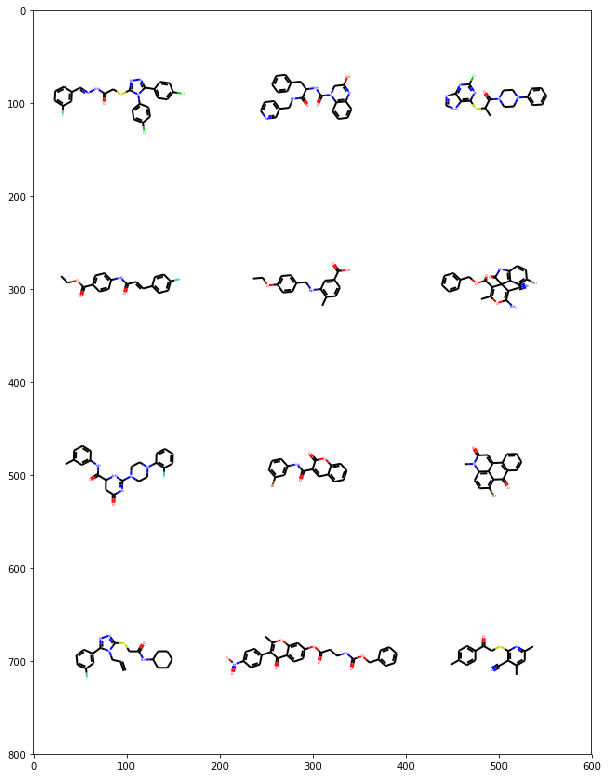

In [143]:
plot_random(0)

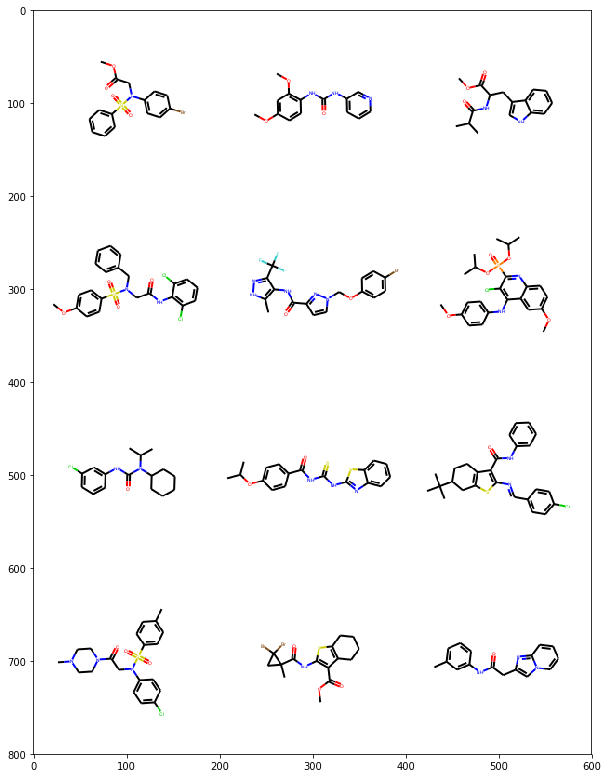

In [144]:
plot_random(1)

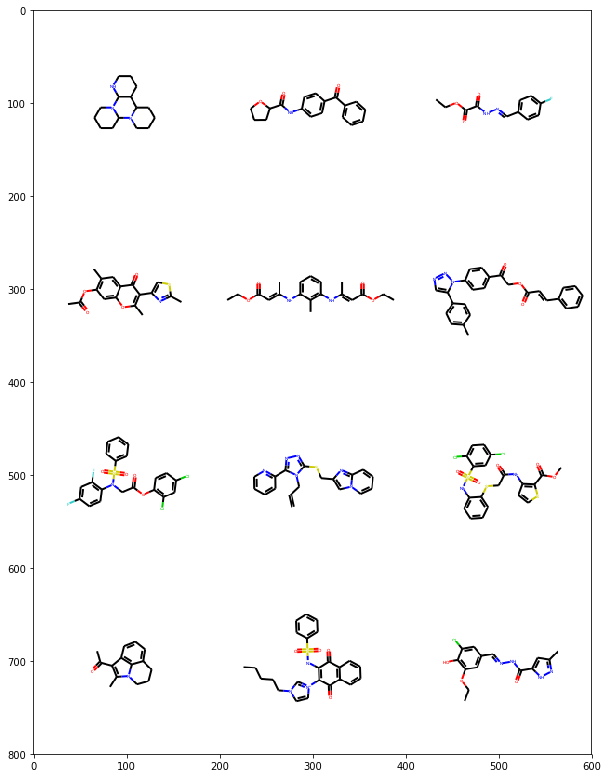

In [145]:
plot_random(2)

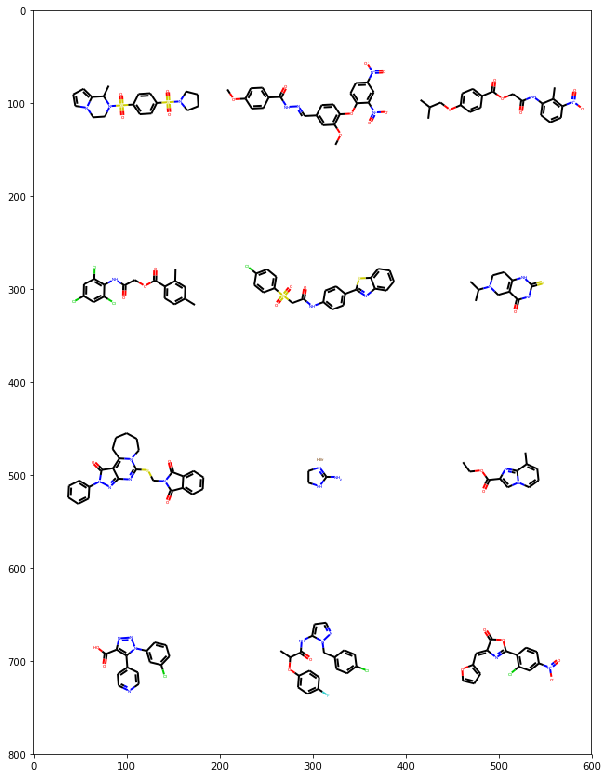

In [146]:
plot_random(3)

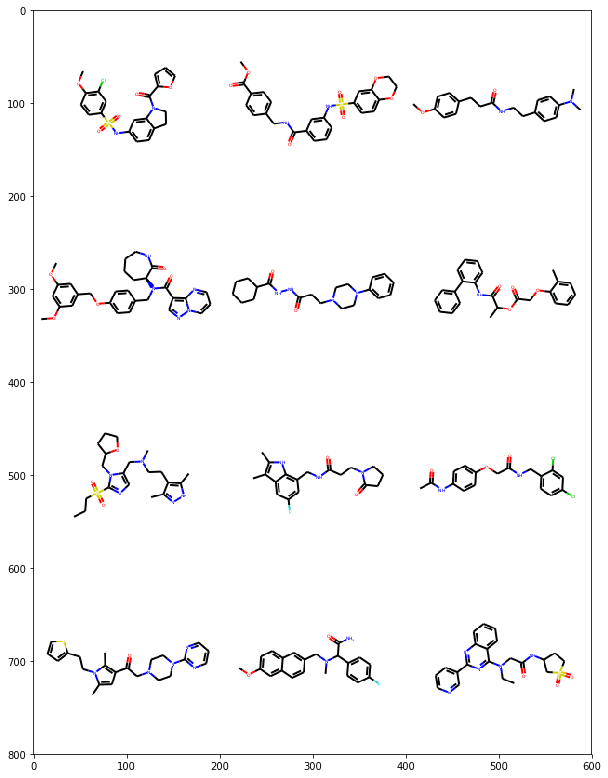

In [147]:
plot_random(4)

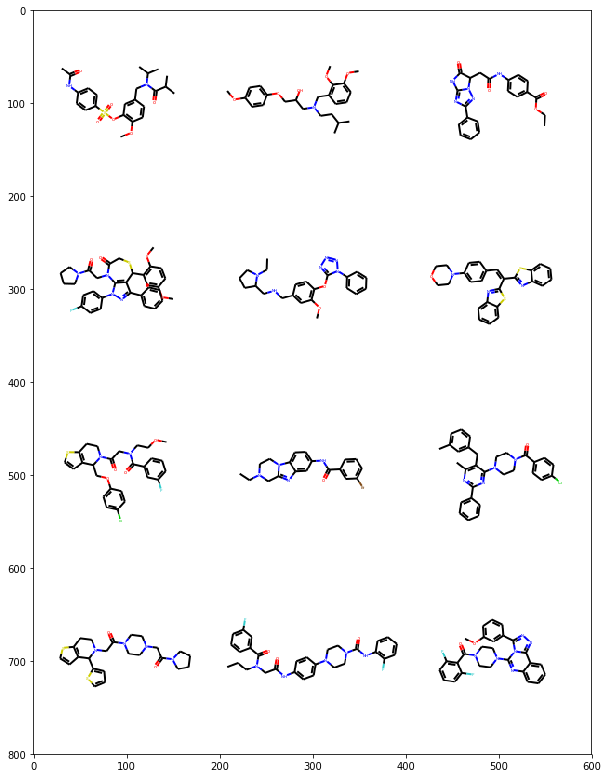

In [148]:
plot_random(5)

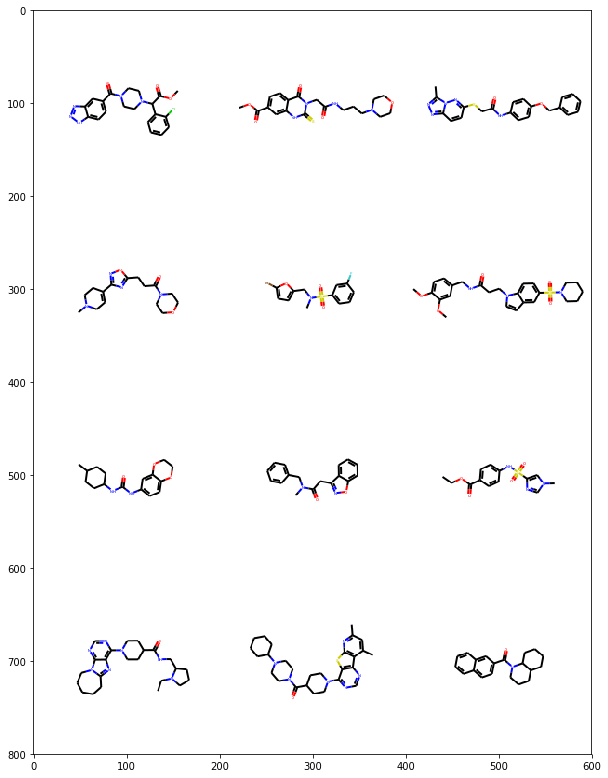

In [149]:
plot_random(6)

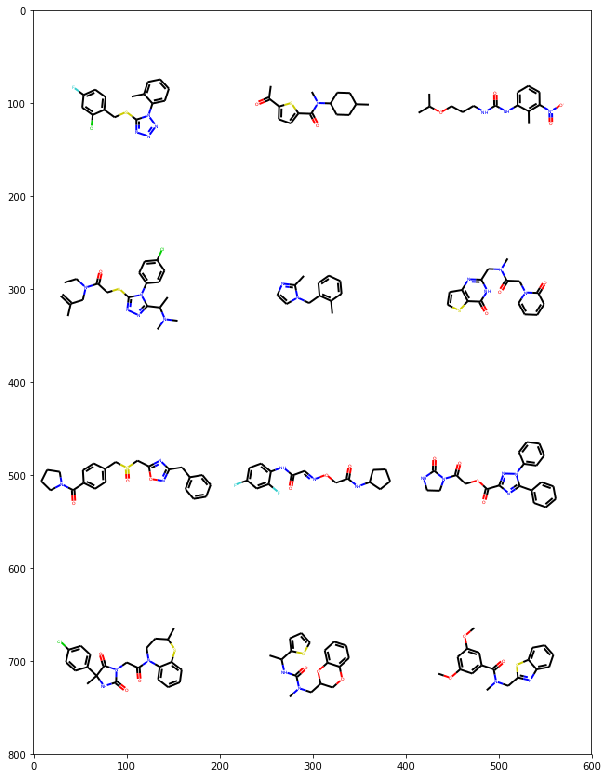

In [150]:
plot_random(7)

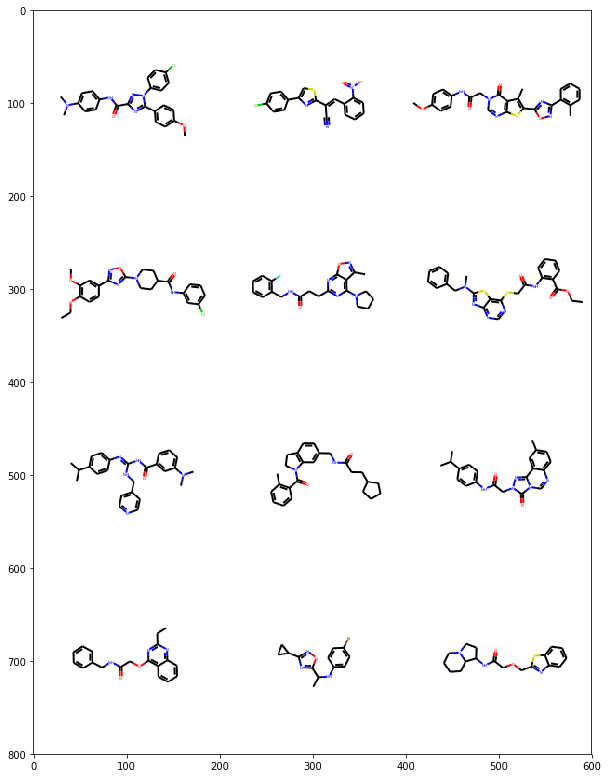

In [151]:
plot_random(8)

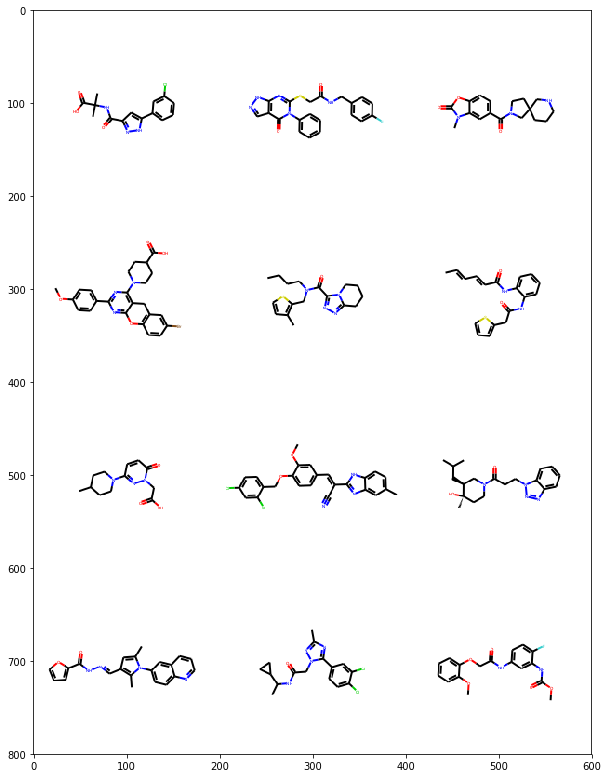

In [152]:
plot_random(9)

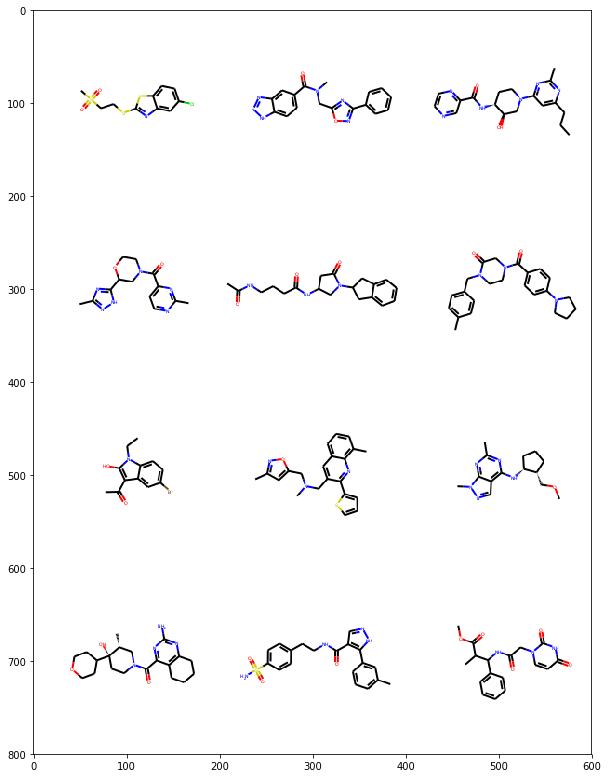

In [153]:
plot_random(10)

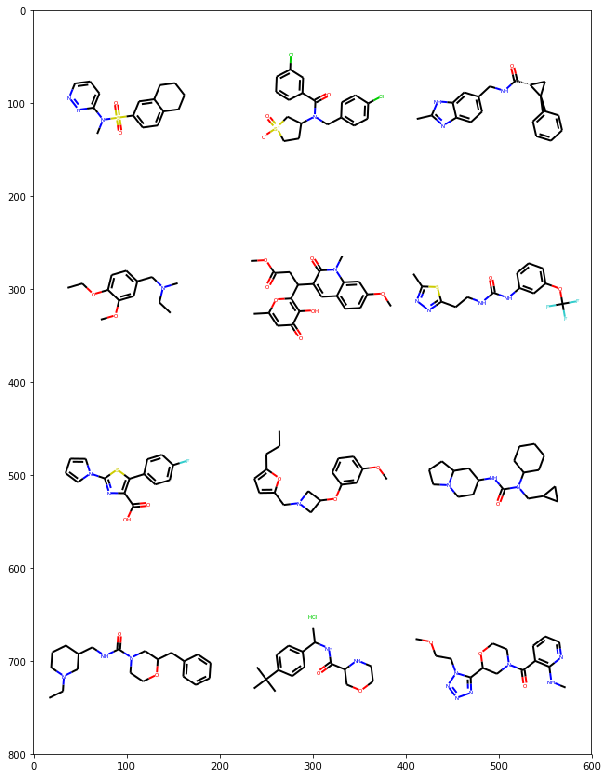

In [154]:
plot_random(11)

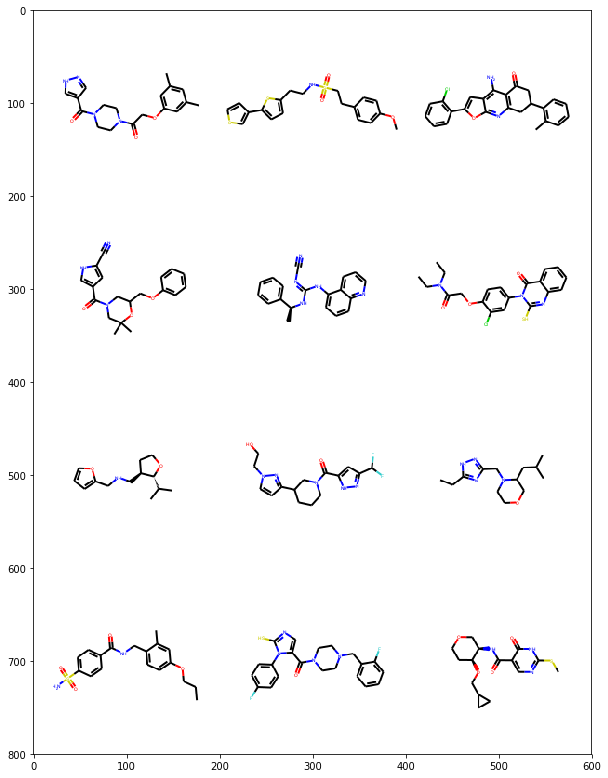

In [155]:
plot_random(12)

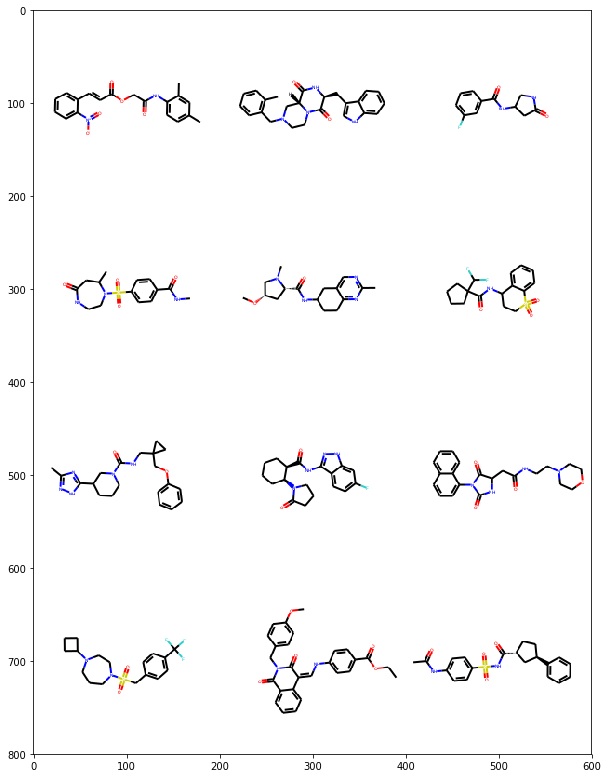

In [156]:
plot_random(13)

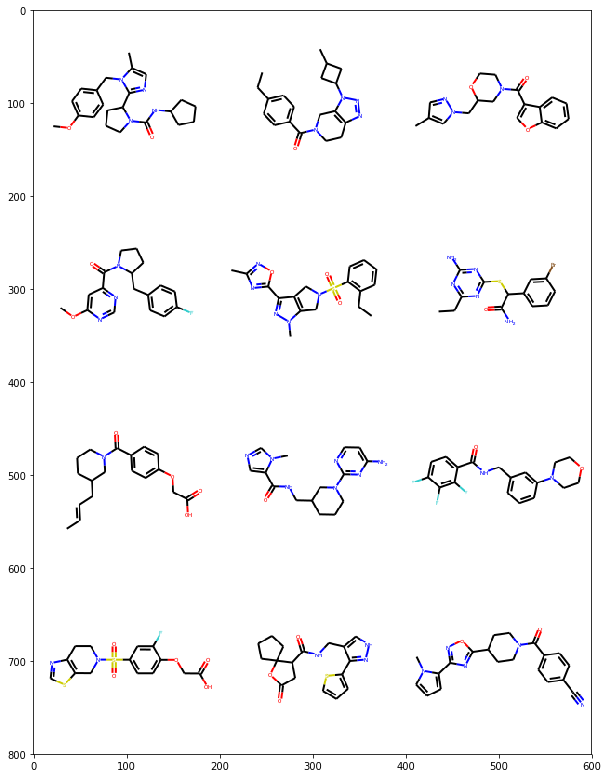

In [157]:
plot_random(14)

In [159]:
all_dists_toMP

array([ 0.5       ,  0.45901639,  0.45238095, ...,  0.32075472,
        0.34545455,  0.        ])

In [161]:
figsize(20, 10)

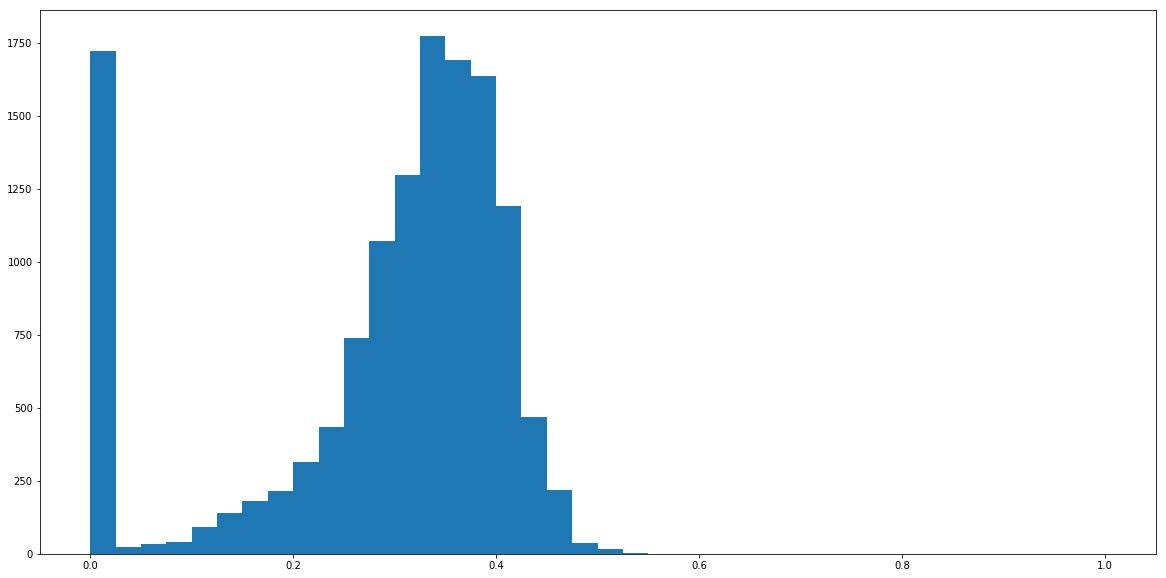

In [162]:
_ = plt.hist(all_dists_toMP, bins=40)

In [163]:
idcs = np.argsort(all_dists_toMP)[-12:]

In [164]:
all_dists_toMP[idcs]

array([ 0.50793651,  0.51219512,  0.51428571,  0.515625  ,  0.52      ,
        0.52      ,  0.52083333,  0.525     ,  0.53846154,  0.54166667,
        0.55813953,  1.        ])

In [176]:
df_tcams_nd.iloc[1].name

'Brc1cc(Br)c2c(c1)C(NCCCNC1CCNc3c(Br)cc(Br)cc31)CCN2'

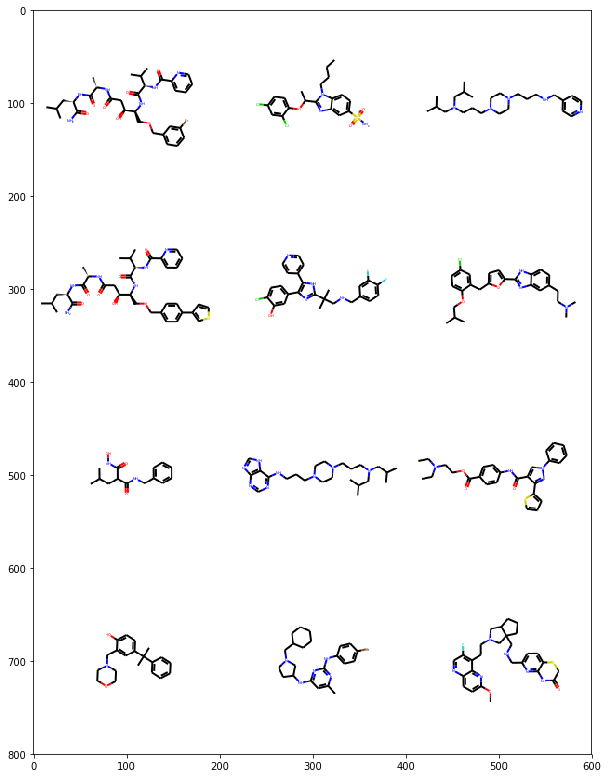

In [178]:
figsize(10, 20)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(df_tcams_nd.iloc[x].name) for x in idcs])
plt.imshow(fig)

In [179]:
for i in range(15):
    ad = np.load('all_dists_long_' + str(i) + '.npy')
    print("File %2d - zero distance : %5d, distance < 0.1 : %5d  distance < 0.3 : %5d, points %d" % 
          (i, np.sum(ad == 0), np.sum(ad < 0.1), np.sum(ad < 0.3), len(ad)))

File  0 - zero distance :   389, distance < 0.1 :   515  distance < 0.3 :  9028, points 499939
File  1 - zero distance :   352, distance < 0.1 :   487  distance < 0.3 :  8870, points 499944
File  2 - zero distance :   305, distance < 0.1 :   401  distance < 0.3 :  5728, points 499824
File  3 - zero distance :   362, distance < 0.1 :   448  distance < 0.3 :  6509, points 499026
File  4 - zero distance :   133, distance < 0.1 :   166  distance < 0.3 :  3881, points 499396
File  5 - zero distance :   105, distance < 0.1 :   137  distance < 0.3 :  3446, points 499308
File  6 - zero distance :   157, distance < 0.1 :   221  distance < 0.3 :  5920, points 498290
File  7 - zero distance :    17, distance < 0.1 :    22  distance < 0.3 :  1825, points 499183
File  8 - zero distance :    58, distance < 0.1 :    78  distance < 0.3 :  2427, points 496725
File  9 - zero distance :    52, distance < 0.1 :    71  distance < 0.3 :  1988, points 499829
File 10 - zero distance :    25, distance < 0.1 : 

In [198]:
figsize(20, 10)

### Do a properly weighted sample from whole distribution

In [243]:
def choose_sample(distance=0.3, size=500000, debug=True):
    counts = []
    for i in range(15):
        ad = np.load('all_dists_long_' + str(i) + '.npy')
        counts.append(np.sum(ad <= distance))
        pass
    total = np.sum(counts)
    if debug:
        print(counts)
        pass
    distances = np.asarray([])
    for i in range(15):
        ad = np.load('all_dists_long_' + str(i) + '.npy')
        to_choose = int(size * counts[i]/float(total))
        if debug:
            print('Choosing', to_choose, 'from file', i)
            pass
        idcs = np.random.choice(ad.shape[0], to_choose)
        distances = np.concatenate((distances, ad[idcs]))
        pass
    return distances

[4132, 3691, 2663, 2767, 1426, 1188, 2412, 497, 813, 689, 471, 216, 119, 474, 86]
Choosing 95453 from file 0
Choosing 85266 from file 1
Choosing 61518 from file 2
Choosing 63920 from file 3
Choosing 32942 from file 4
Choosing 27444 from file 5
Choosing 55719 from file 6
Choosing 11481 from file 7
Choosing 18781 from file 8
Choosing 15916 from file 9
Choosing 10880 from file 10
Choosing 4989 from file 11
Choosing 2749 from file 12
Choosing 10949 from file 13
Choosing 1986 from file 14


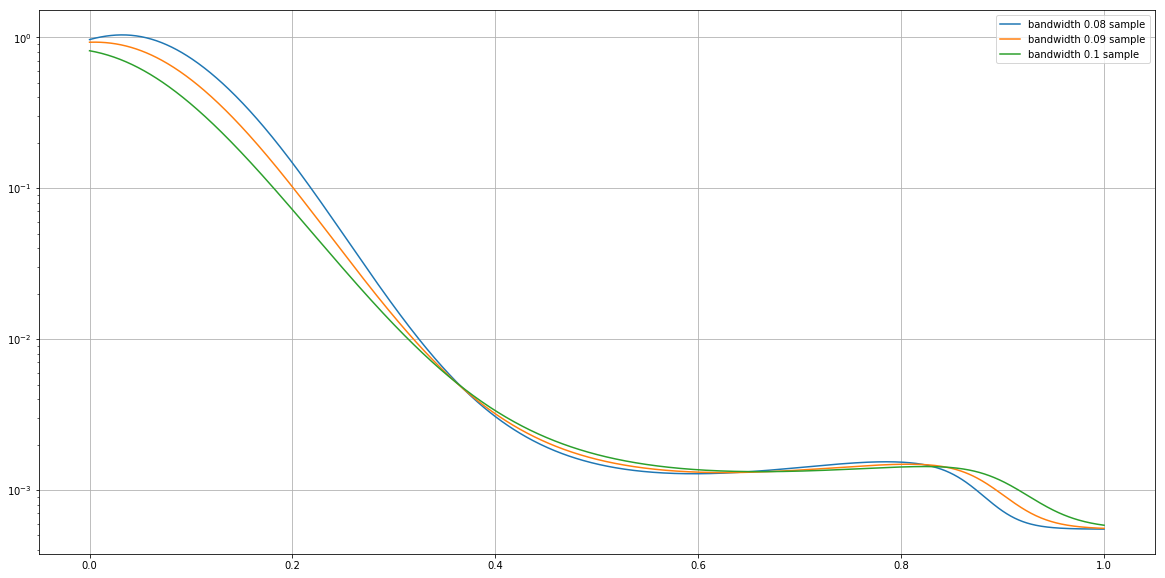

In [205]:
sample_dists = choose_sample(distance=0.25)
fa = 13533/1985056
for bandwith in [ 0.08, 0.09, 0.1,]:
    X = sample_dists[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')
plt.yscale('log')

[499939, 499944, 499824, 499026, 499396, 499308, 498290, 499183, 496725, 499829, 499931, 499892, 499965, 499895, 239894]
Choosing 34568 from file 0
Choosing 34569 from file 1
Choosing 34560 from file 2
Choosing 34505 from file 3
Choosing 34531 from file 4
Choosing 34525 from file 5
Choosing 34454 from file 6
Choosing 34516 from file 7
Choosing 34346 from file 8
Choosing 34561 from file 9
Choosing 34568 from file 10
Choosing 34565 from file 11
Choosing 34570 from file 12
Choosing 34565 from file 13
Choosing 16587 from file 14


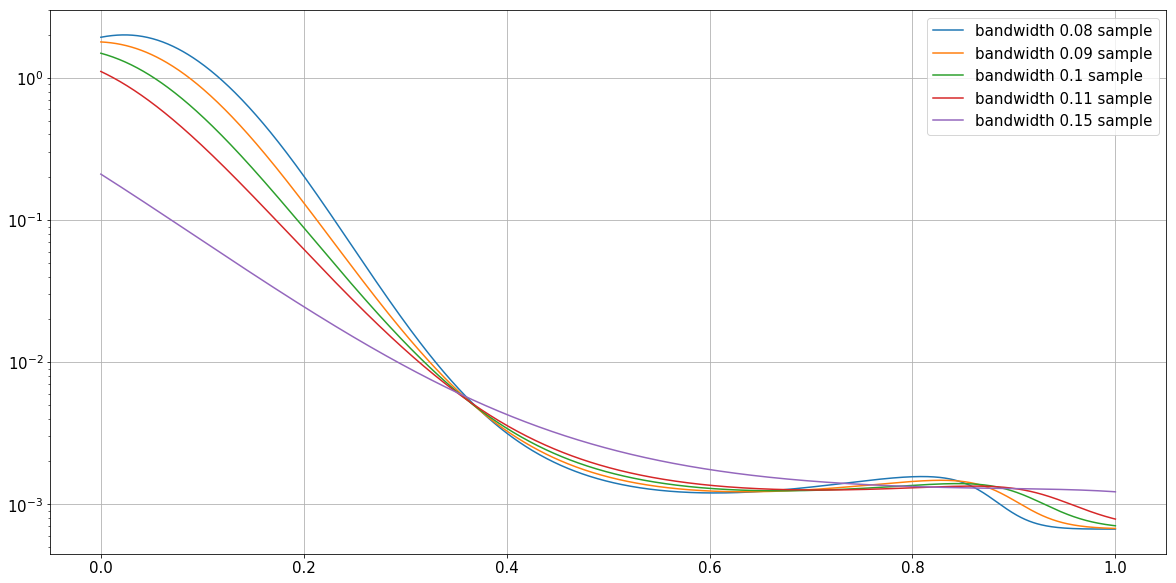

In [374]:
sample_dists = choose_sample(distance=1.0)
fa = 13533/1985056
for bandwith in [ 0.08, 0.09, 0.1, 0.11, 0.15]:
    X = sample_dists[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densRA = kde.score_samples(X_plot)
    X = all_AdistsN2[~np.isnan(all_AdistsN2)][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwith).fit(X)
    log_densAA = kde.score_samples(X_plot)  
    plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRA), label='bandwidth ' + str(bandwith) + ' sample')
grid(True)
legend(loc='best')
plt.yscale('log')

In [206]:
fa

0.006817439911015105

In [209]:
sum(all_dists_toMP == 0)/ all_dists_toMP.shape

array([ 0.12876116])

In [211]:
sum(all_dists_toMP < 0.3) / all_dists_toMP.shape

array([ 0.36744954])

In [213]:
log_densAA[:10]

array([-0.19307769, -0.1816437 , -0.17027528, -0.15897242, -0.14773506,
       -0.13656317, -0.1254567 , -0.11441563, -0.1034399 , -0.09252948])

In [214]:
kde.score_samples(0)

array([-0.19307769])

### Plan...

- Take a bunch of different sizes in the range [0.. 0.4]
- select 100K points according to those criteria.
- Find, by binary search, to 1 dp, the bandwidth that gives 1.0 at 0.
- Then choose various distances to see which gives 1.0 with that bandwidth.
- then choose as many points as possible with that 

In [240]:
def calc_beta(d, debug=True):
    
    upper = 0.15
    lower = 0.05
    sample_dists = choose_sample(distance=d, size=100000, debug=False)
    
    while (upper - lower) > 0.005:

        mid = (upper + lower)/2
        
        kdeM = KernelDensity(kernel='gaussian', bandwidth=mid).fit(sample_dists[:,None])
        log_densRAM = kdeM.score_samples(X_plot[0,None])
        f0M = fa * np.exp(log_densAA[0] - log_densRAM[0])

        if debug:
            print(f0M)
        if f0M > 1:
            if debug:
                print('Setting lower to', mid)
            lower = mid
        else:
            if debug:
                print('Setting upper to', mid)
            upper = mid
    
    return mid
            


In [278]:
def estimate_f0(sample_dists, bandwidth):
    kdem = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sample_dists[:,None])
    log_densRAM = kdem.score_samples(X_plot[0,None])
    f0M = fa * np.exp(log_densAA[0] - log_densRAM[0])
    return f0M

In [269]:
bdwiths = []
for dist in np.arange(0, 0.5, 0.05):
    for j in range(20):
        bdwiths.append(calc_beta(dist, debug=False))

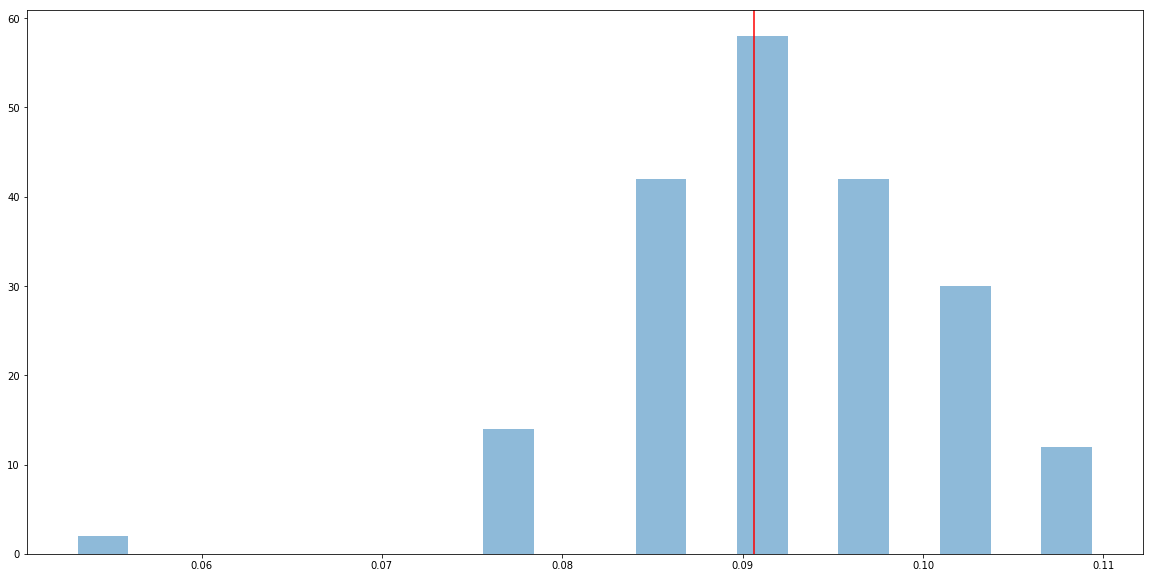

In [270]:
v = np.median(bdwiths)
_ = plt.hist(bdwiths, alpha=0.5, bins=20); plt.axvline(x=v, color='red')

In [271]:
np.median(bdwiths)

0.090625000000000011

In [279]:
ds = np.arange(0, 0.6, 0.05)
means = []
stds = []
for d in ds:
    vals = [estimate_f0(choose_sample(distance=d, debug=False, size=100000), bandwidth=np.median(bdwiths)) 
            for i in range(10)]
    means.append(np.mean(vals))
    stds.append(np.std(vals)/np.sqrt(10))
    pass

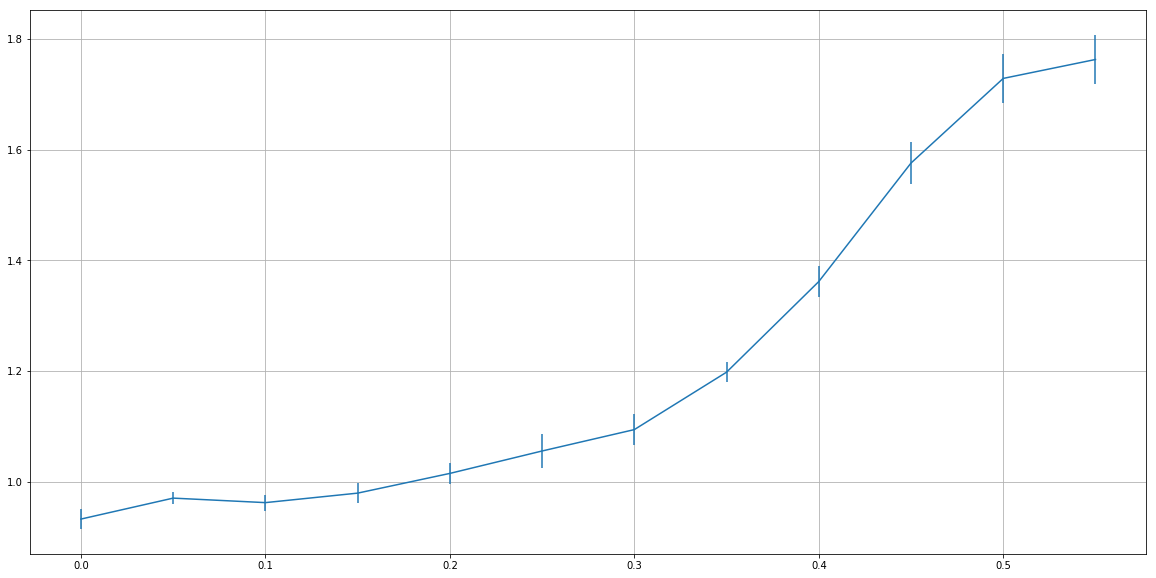

In [281]:
plt.errorbar(ds, means, yerr=stds)
grid(True)

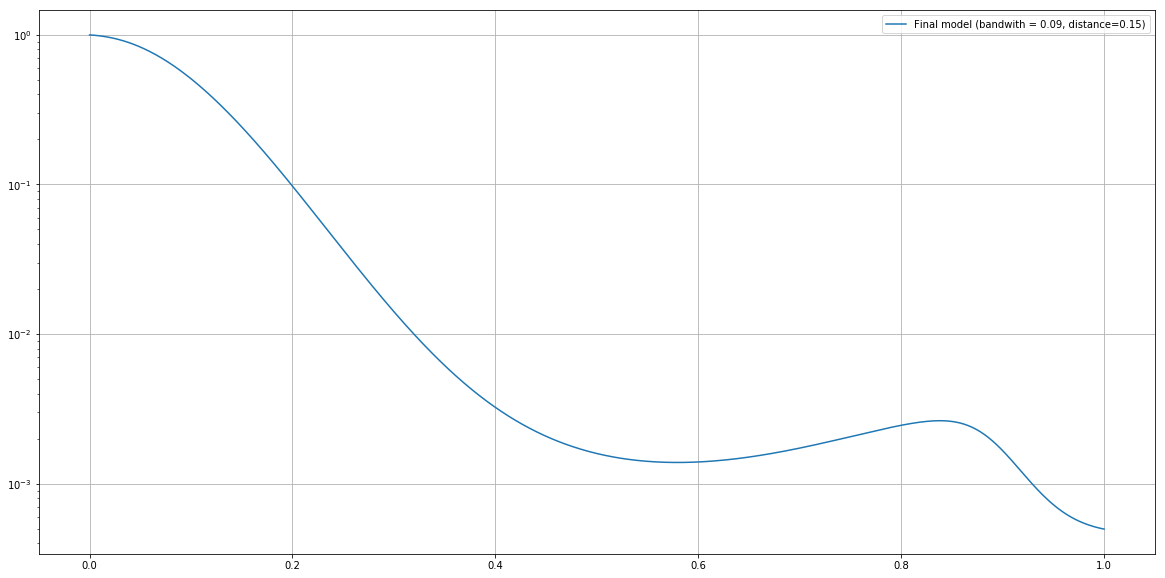

In [294]:
np.random.seed(42)
big_sample = choose_sample(distance=0.15, size=2000000)
kdeF = KernelDensity(kernel='gaussian', bandwidth=0.09).fit(big_sample[:,np.newaxis])
log_densRAF = kdeF.score_samples(X_plot)
plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRAF), label='Final model (bandwith = 0.09, distance=0.15)')
grid(True)
legend(loc='best')
plt.yscale('log')

In [282]:
# OK - final choice:  bandwidth = 0.09, d = 0.15

[973, 818, 683, 730, 286, 253, 467, 55, 153, 135, 82, 33, 27, 110, 17]
Choosing 100891 from file 0
Choosing 84819 from file 1
Choosing 70821 from file 2
Choosing 75694 from file 3
Choosing 29655 from file 4
Choosing 26233 from file 5
Choosing 48423 from file 6
Choosing 5703 from file 7
Choosing 15864 from file 8
Choosing 13998 from file 9
Choosing 8502 from file 10
Choosing 3421 from file 11
Choosing 2799 from file 12
Choosing 11406 from file 13
Choosing 1762 from file 14


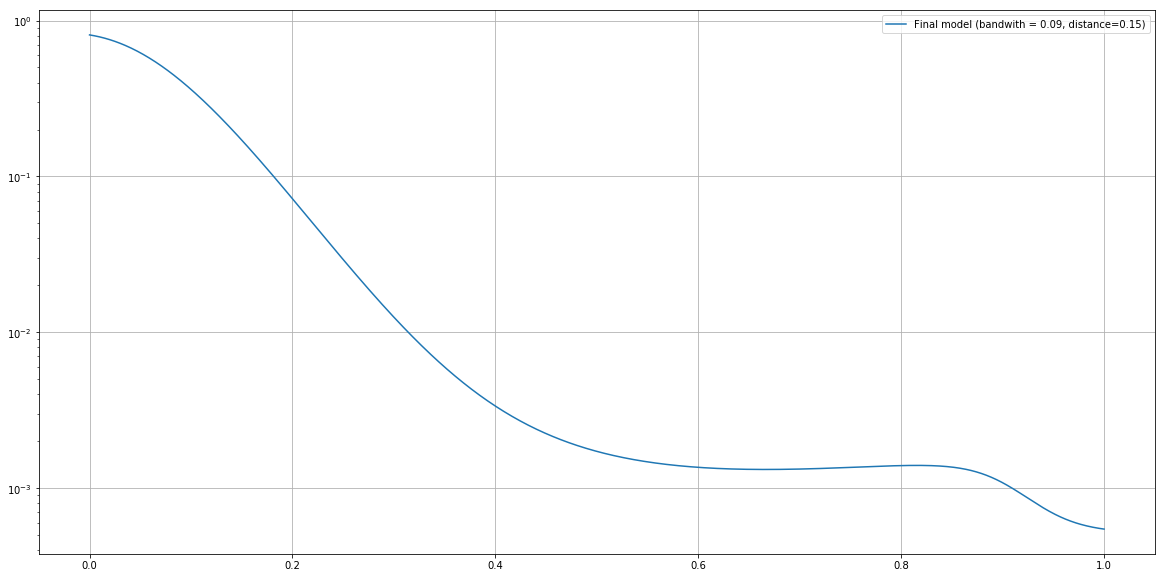

In [298]:
np.random.seed(42)
big_sample = choose_sample(distance=0.15, size=500000)
kdeF = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(big_sample[:,np.newaxis])
log_densRAF = kdeF.score_samples(X_plot)
plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRAF), label='Final model (bandwith = 0.09, distance=0.15)')
grid(True)
legend(loc='best')
plt.yscale('log')

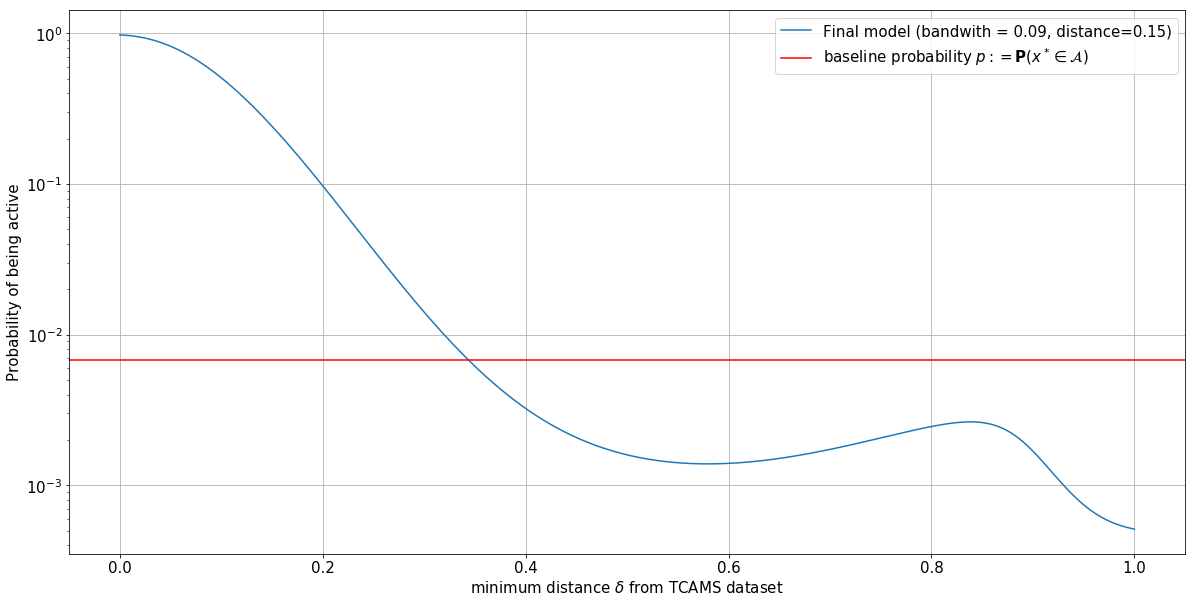

In [372]:
np.random.seed(42)
#big_sample = choose_sample(distance=0.15, size=2000000)
#kdeF = KernelDensity(kernel='gaussian', bandwidth=0.09).fit(big_sample[:,np.newaxis])
#log_densRAF = kdeF.score_samples(X_plot)
plt.plot(X_plot[:,0], fa * np.exp(log_densAA - log_densRAF), label='Final model (bandwith = 0.09, distance=0.15)')
plt.axhline(y=fa, color='red', label=r'baseline probability $p := \mathbf{P}(x^*\in \mathcal{A})$')
grid(True)
legend(loc='best')
plt.ylabel('Probability of being active')
plt.xlabel(r'minimum distance $\delta$ from TCAMS dataset')
plt.yscale('log')
savefig('figures/frac_active.png')

## Spline fitting for the extrapolation

In [303]:
fc_rf_hdr = {}
fc_lr_hdr = {}
#ctr_hdr = {}  # this tells you the mean distance...

def rank(x):
    return np.argsort(np.argsort(x))/(len(x) + 0.) - 0.5

bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9]

# stats.run_big_fit(full_df.dropna(subset=['POTENCY']))

#joblib.dump(fc_rf_hdr, 'modelling/rf_fc_results')
#joblib.dump(fc_lr_hdr, 'modelling/rdg_fc_results')
#joblib.dump(ctr_hdr, 'modelling/ctr_results')
fc_rf_hdr = joblib.load('modelling/rf_fc_results')
fc_lr_hdr = joblib.load('modelling/rdg_fc_results')
#ctr_hdr = joblib.load('modelling/ctr_results')


#result_hdr = {'rf' : [], 'rdg' : [], 'rfrk' : [], 'rdgrk' : [], 
#             'rfb' : [], 'rdgb' : [], 'rfrkb' : [], 'rdgrkb' : [], 
#             }#
#
#for i in range(len(bins)):
#    rf_beta, rf_r2 = stats.regress(full_df.POTENCY.values, [fc_rf_hdr[i],], do_print=False, one=True)
#    rdg_beta, rdg_r2 = stats.regress(full_df.POTENCY.values, [fc_lr_hdr[i],], do_print=False, one=True)
#    rfr_beta, rfr_r2 = stats.regress(rank(full_df.POTENCY.values), [rank(fc_rf_hdr[i]),], 
#                                     do_print=False)
#    rdgr_beta, rdgr_r2 = stats.regress(rank(full_df.POTENCY.values), [rank(fc_lr_hdr[i]),], 
#                                       do_print=False)   
#    
#    result_hdr['rf'].append(rf_r2)
#    result_hdr['rfb'].append(rf_beta[0])
#    result_hdr['rdg'].append(rdg_r2)
#    result_hdr['rdgb'].append(rdg_beta[0])
#    result_hdr['rfrk'].append(rfr_r2)
#    result_hdr['rfrkb'].append(rfr_beta[0])
#    result_hdr['rdgrk'].append(rdgr_r2)
#    result_hdr['rdgrkb'].append(rdgr_beta[0])
       
result_hdr = joblib.load('results/summary_results_tcnd')

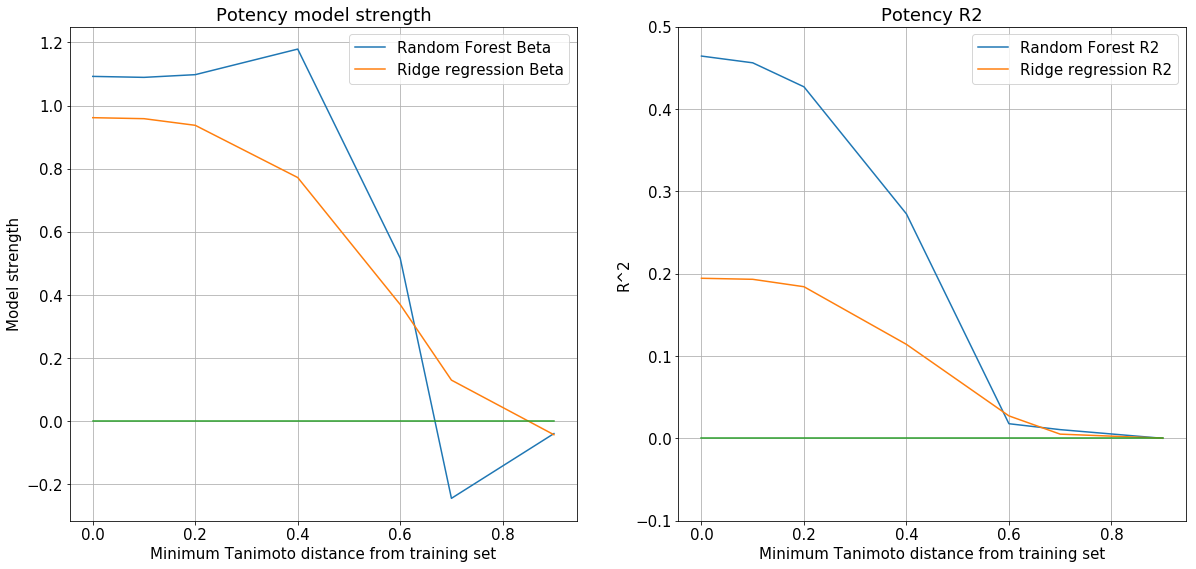

In [305]:
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7,  0.9]
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.plot(bins, result_hdr['rfb'], label='Random Forest Beta')
plt.plot(bins, result_hdr['rdgb'], label='Ridge regression Beta'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('Model strength')
plt.grid(True); plt.legend(loc='best')
plt.title('Potency model strength')
plt.subplot(222)
plt.plot(bins, result_hdr['rf'], label='Random Forest R2')
plt.plot(bins, result_hdr['rdg'], label='Ridge regression R2'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('R^2')
plt.ylim((-0.1, 0.5))
plt.grid(True); plt.legend(loc='best')
_ = plt.title('Potency R2')

In [306]:
result_hdr['rfb']

[1.0924606768676854,
 1.0893840243987567,
 1.0979490151629734,
 1.1789742576450628,
 0.51675566551085228,
 -0.24397745197382709,
 -0.038915842336462142]

In [310]:
import scipy.interpolate as interpolate

t: [ 0.   0.   0.   0.   0.   0.3  0.5  0.9  0.9  0.9  0.9  0.9]
c: [ 1.09246068  1.11871233  0.98621816  1.48984253  0.78126463 -1.80359785
 -0.03891584  0.          0.          0.          0.          0.        ]
k: 4



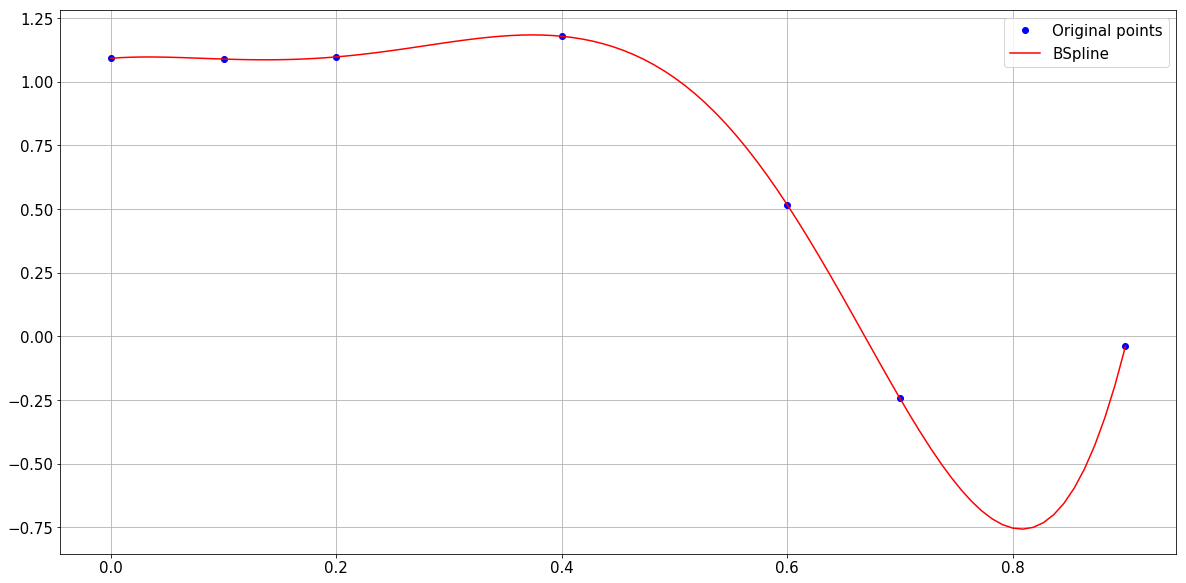

In [355]:
x = np.asarray(bins)
y = np.asarray(result_hdr['rfb'])

t, c, k = interpolate.splrep(x, y, s=0, k=4)
print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
rfb_spline = interpolate.BSpline(t, c, k, extrapolate=True)

plt.plot(x, y, 'bo', label='Original points')
plt.plot(xx, rfb_spline(xx), 'r', label='BSpline')
#plt.plot(np.linspace(0, 1), interpolate.spline(bins, result_hdr['rfb'], np.linspace(0, 1)))
plt.grid()
plt.legend(loc='best')
plt.show()

In [356]:
result_hdr = joblib.load('results/summary_results_tcnd')
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9]
inactive_level = 3.5
active_level = np.mean(full_df.POTENCY.values)
rf_beta = partial(np.interp, xp=np.linspace(0, 1), fp=rfb_spline(np.linspace(0, 1)))

In [357]:
frac_active = partial(np.interp, xp=X_plot[:,0], fp=(fa * np.exp(log_densAA - log_densRAF)).clip(0, 1))

In [358]:
from malaria import mp_utils, stats

full_models = stats.fit_models(full_df, full_df)

full_models['rfb'] = rf_beta
full_models['frac_act'] = frac_active
full_models['inactive_level'] = inactive_level
full_models['active_level'] = active_level

In [329]:
def calc_sigma(distance, ia=inactive_level):
    
    fa = frac_active(distance)
    act_sigma = 0.27 + 0.33 * distance
    
    rs = active_level - ia
    
    e_x2 = fa * (rs*rs + act_sigma * act_sigma)
    ex_2 = (fa * rs)**2
    return np.sqrt(e_x2 - ex_2)

In [331]:
gd = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] >= 7.6) & (df_tcams_nd['PCT_INHIB_HEPG2'] <= 5)]
# We're going to use the compounds with values < 7.5 for fitting (see Bioinformatics paper)
df_fit = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] <= 7.5)]
# potency random forest model
# set seed so replicable
np.random.seed(42)
pot_model = model_dict['rf']['m'](**model_dict['rf']['kw']).fit(
    np.asarray([fp for fp in df_fit.fps.values]), df_fit.pXC50_3D7.values)


In [332]:
# We need the minumum distances (for our model) for the good compounds from the fit dataset...
gd_dists = np.min(cdist(np.asarray([fp for fp in gd.fps.values]), 
                        np.asarray([fp for fp in df_fit.fps.values]), metric='jaccard'), axis=1)

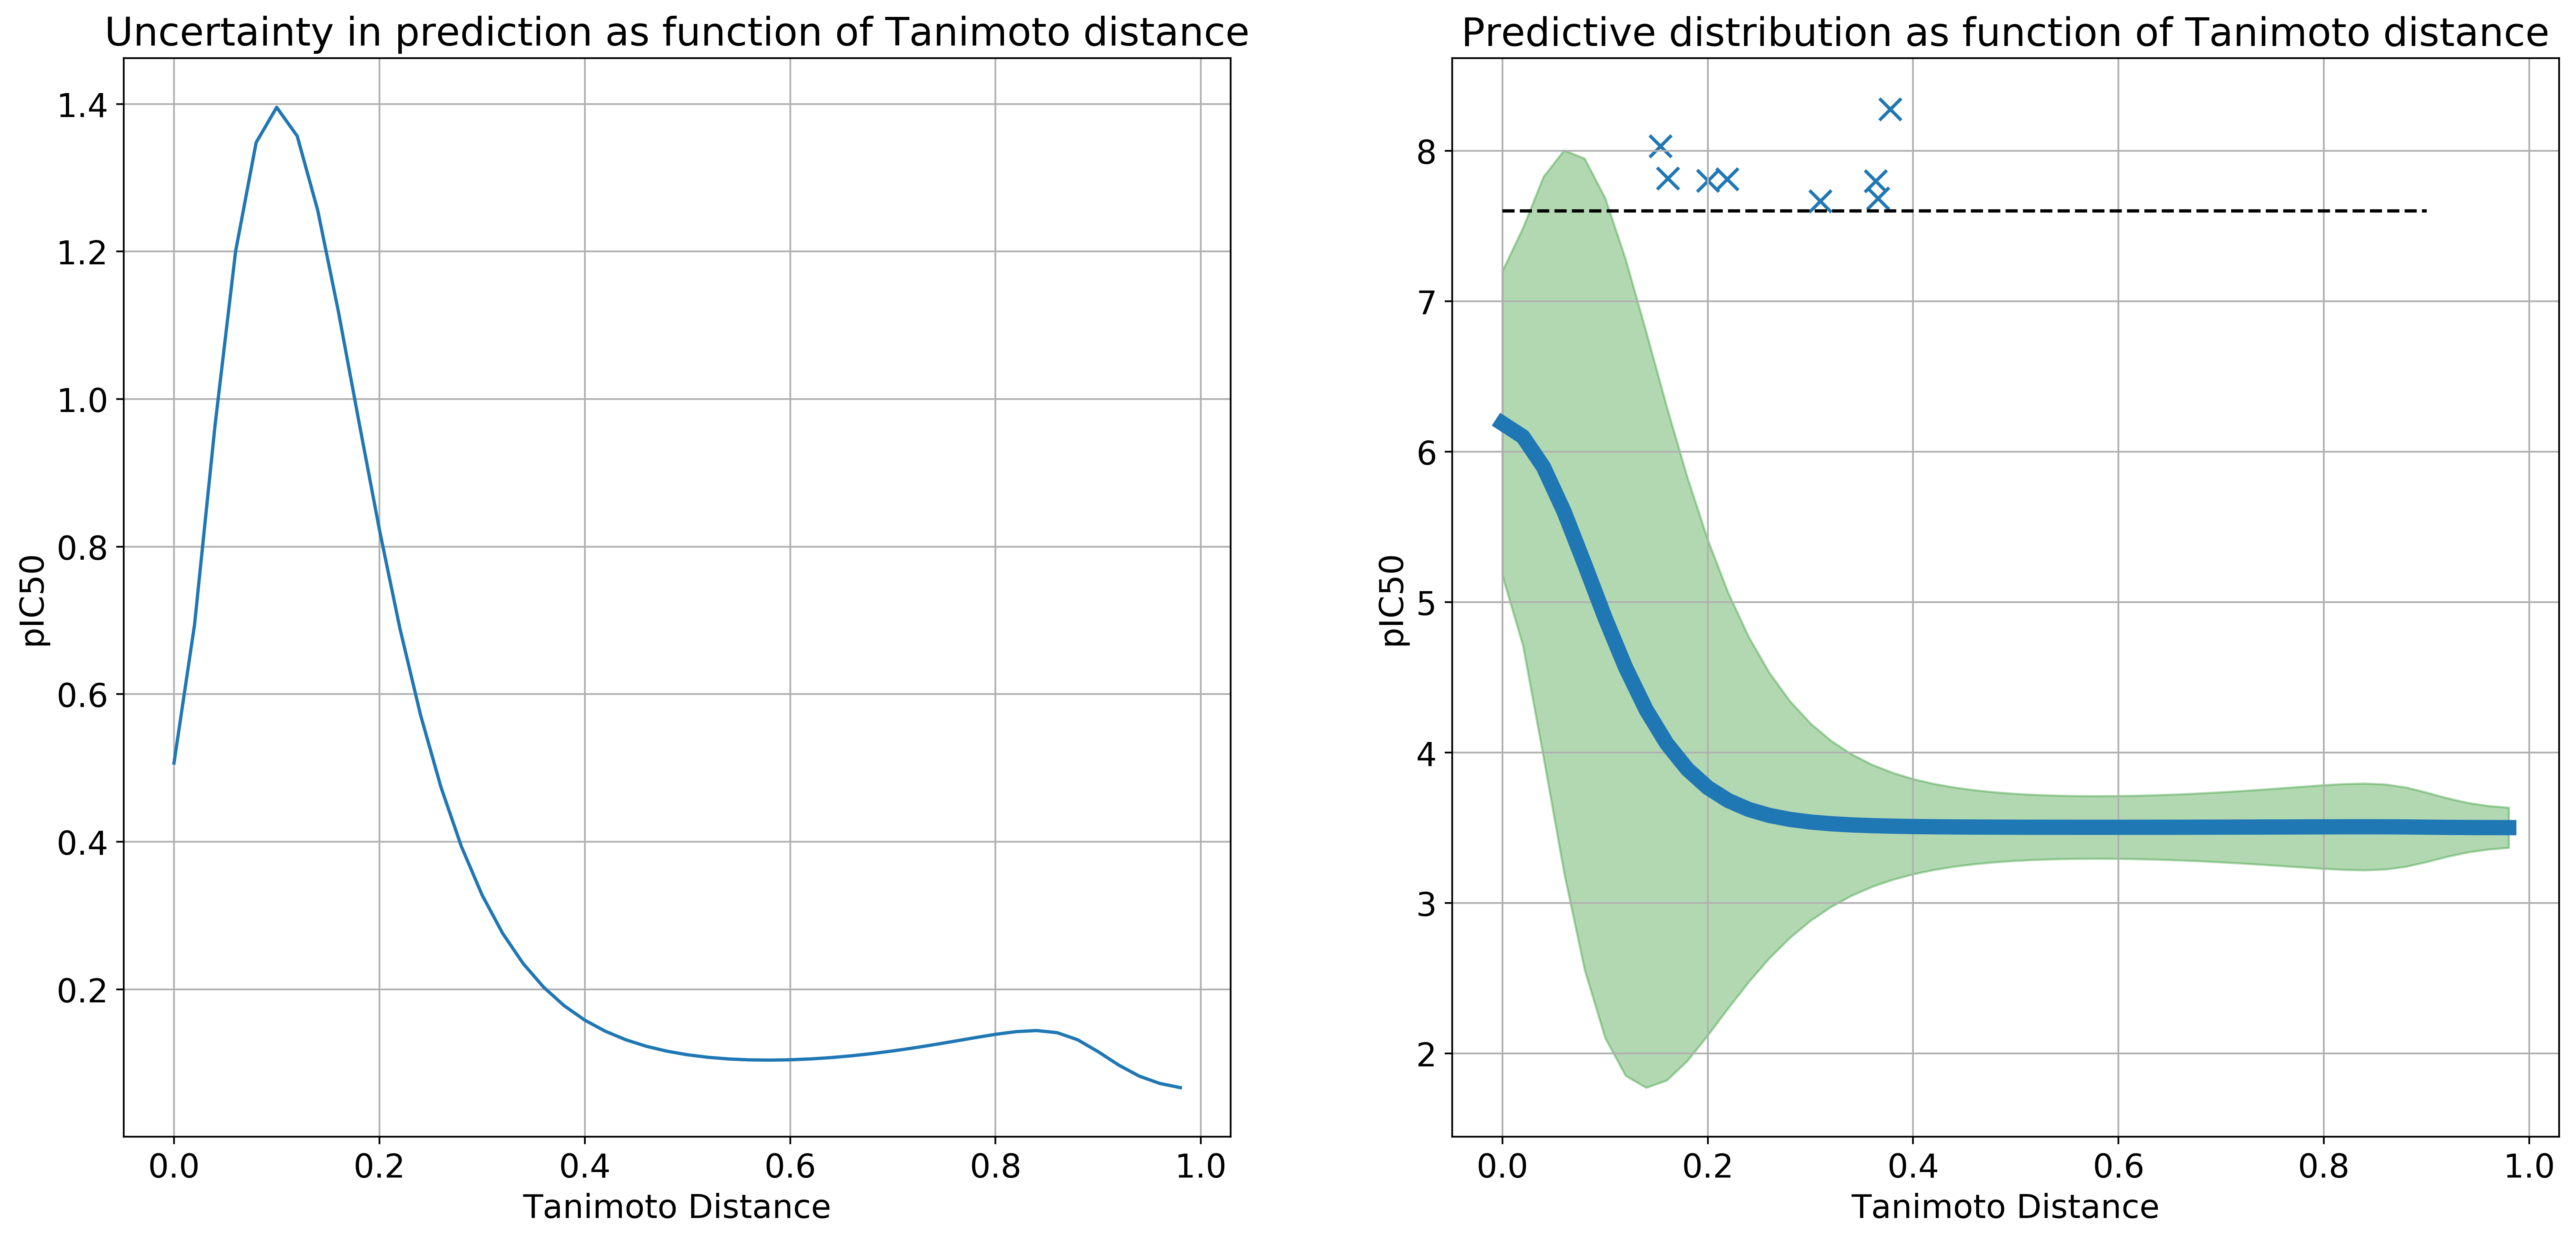

In [333]:
xv = np.arange(50)/50
siga = np.vectorize(calc_sigma)(xv)

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(221)
plt.plot(xv, siga, label='Standard Deviation (uncertainty in prediction)'); 
plt.xlabel('Tanimoto Distance')
plt.ylabel('pIC50')
plt.grid(True)
plt.title('Uncertainty in prediction as function of Tanimoto distance')
plt.subplot(222)
plt.grid(True)
plt.xlabel('Tanimoto Distance')
yv = (1-frac_active(xv)) * inactive_level + frac_active(xv) * active_level
plt.fill_between(xv, yv - 2*siga, yv + 2*siga, color='g', alpha=0.3, 
                 label='Predictive distribution approximation (95%)')
plt.plot(xv, yv, linewidth=7.0)
_ = plt.hlines(7.6, 0, 0.9, linestyles='--', label='Threshold level in our test')
_ = plt.title('Predictive distribution as function of Tanimoto distance')
plt.scatter(gd_dists, gd.pXC50_3D7.values, marker='x', s=100, label='Location of target compounds')
_= plt.ylabel('pIC50')

In [336]:
gd_fps = np.asarray([fp for fp in gd.fps.values])
gd_active_potency = pot_model.predict(gd_fps)
gd_frac_active = full_models['frac_act'](gd_dists)
gd_rf_beta = full_models['rfb'](gd_dists)
gd_predicted_potency = gd_frac_active * (gd_rf_beta * gd_active_potency + (1-gd_rf_beta)*active_level) +\
    (1-gd_frac_active)*inactive_level

In [337]:
def run_experiment2(num_choice=100*1000, to_choose=20, target=7.6, A=8, gdpp=gd_predicted_potency, gdd=gd_dists):
    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_predicted_potency[:num_choice], gdpp))
    
    distances = np.concatenate((mp1.min_dist.values[:num_choice], gdd))
    uncertainties = np.vectorize(calc_sigma)(distances)
    
    log_lik =  scipy.stats.norm.logcdf((potency - target)/uncertainties)
    
    x = sum(np.argsort(log_lik)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(log_lik)[-to_choose:]

In [338]:
def prob_random(n, A=8, T=20):
    x = 1
    num = n - A
    den = n
    for i in range(T):
        x *= num/den
        num -= 1
        den -= 1
    return 1-x

In [339]:
mp1 = pd.read_pickle('test_df')

In [340]:
import scipy

In [341]:
mp_fps = np.asarray([fp for fp in mp1.fps.values])

mp_active_potency = pot_model.predict(mp_fps)
mp_frac_active = full_models['frac_act'](mp1.min_dist.values)
mp_rf_beta = full_models['rfb'](mp1.min_dist.values)
molport_predicted_potency = mp_frac_active * (mp_rf_beta * mp_active_potency + (1-mp_rf_beta)*active_level) +\
    (1-mp_frac_active)*inactive_level
molport_predicted_potency[np.isnan(molport_predicted_potency)] = 0.

In [342]:
def run_experiment(num_choice=100*1000, to_choose=20,  A=8, gdpp=gd_predicted_potency):

    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((molport_predicted_potency[:num_choice], gdpp))
    
    x = sum(np.argsort(potency)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(potency)[-to_choose:]

In [343]:
_ = run_experiment(30*1000)

Probability of success if random 0.00532
Failed


In [344]:
_ = run_experiment(20*1000)

Probability of success if random 0.00797
Succeeded: 2 found


In [345]:
_ = run_experiment()

Probability of success if random 0.00160
Failed


In [346]:
_ = run_experiment2()

Probability of success if random 0.00160
Failed


In [347]:
def calc_sigma_active(distance):

    act_sigma = 0.27 + 0.33 * distance    
    return act_sigma

In [348]:
def run_experiment3(num_choice=100*1000, to_choose=20, target=7.6, A=8, gdap=gd_active_potency, gdd=gd_dists):

    print('Probability of success if random %.5f' % prob_random(num_choice + A, A=A, T=to_choose))
    
    potency = np.concatenate((mp_active_potency[:num_choice], gdap))
    
    distances = np.concatenate((mp1.min_dist.values[:num_choice], gdd))
    au = np.vectorize(calc_sigma_active)(distances)
    
    #log_lik =  scipy.stats.norm.logcdf((potency - target)/uncertainties)
    
    log_lik = np.log(frac_active(distances)) + scipy.stats.norm.logcdf((potency-target)/au)
    x = sum(np.argsort(log_lik)[-to_choose:] > num_choice)
    if (x > 0):
        print('Succeeded: %d found' % x)
    else:
        print('Failed')
    return np.argsort(log_lik)[-to_choose:], log_lik[np.argsort(log_lik)[-to_choose:]]

In [349]:
_ = run_experiment3()

Probability of success if random 0.00160
Succeeded: 2 found


In [350]:
_ = run_experiment3(200*1000)

Probability of success if random 0.00080
Succeeded: 2 found


In [351]:
_ = run_experiment3(480*1000)

Probability of success if random 0.00033
Succeeded: 2 found


In [352]:
faa = frac_active(np.arange(0, 1, 0.01))
act_sigmas = calc_sigma_active(np.arange(0, 1, 0.01))
one_pct_line = np.zeros_like(faa)
one_pct_line[faa <= 0.01] = inactive_level
one_pct_line[faa > 0.01] = (active_level + act_sigmas * scipy.stats.norm.ppf(faa).clip(-4,4))[faa > 0.01]

In [353]:
def get_contour_ll_line(target=7.6, start_point=6.5):
    """
    Gets the log-likelihood as a function of distance (log probability of a compound at distance
    d from the starting point having activity >= target).
    """
    d = np.arange(0, 1, 0.01)
    betas = full_models['rfb'](d)
    active_means = betas * start_point + (1 - betas) * active_level
    return np.log(frac_active(d)) +\
        scipy.stats.norm.logcdf((active_means-target)/np.vectorize(calc_sigma_active)(d))

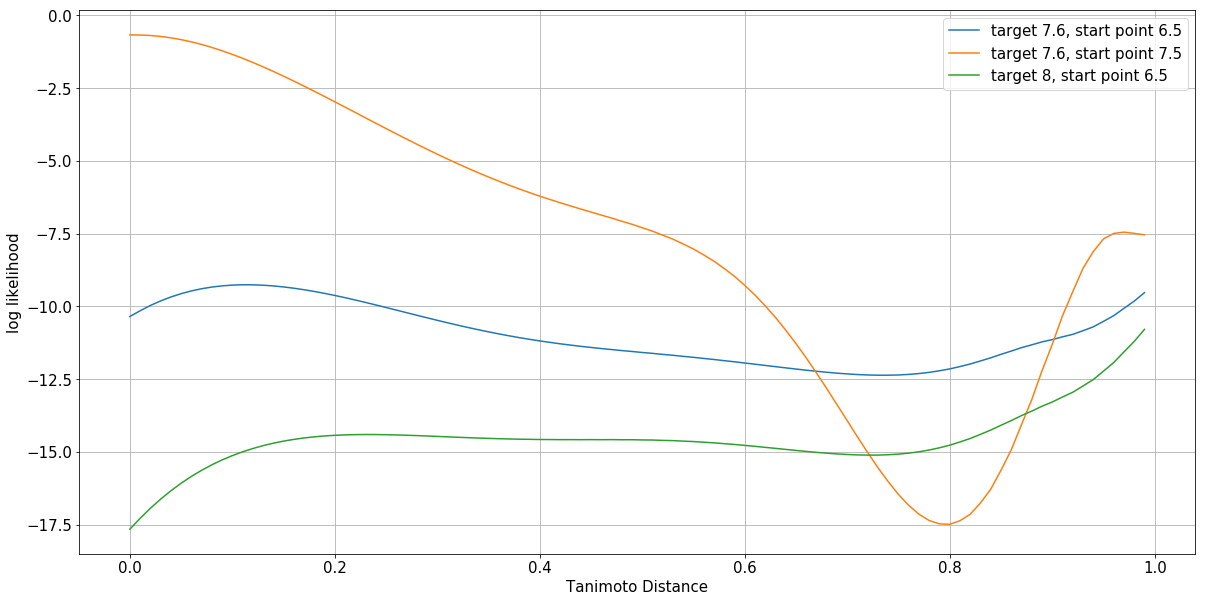

In [359]:
d = np.arange(0, 1, 0.01)
plot(d, get_contour_ll_line(), label='target 7.6, start point 6.5')
plot(d, get_contour_ll_line(start_point=7.5), label='target 7.6, start point 7.5')
plot(d, get_contour_ll_line(target=8), label='target 8, start point 6.5')
ylabel('log likelihood')
xlabel('Tanimoto Distance')
legend(loc='best')
savefig("figures/ll_contour_lines.png")
grid(True)

### Using all compounds with activity > 7.6

In [360]:
gd2 = df_tcams_nd.loc[(df_tcams_nd['pXC50_3D7'] >= 7.6)]

In [361]:
# We need the minumum distances (for our model) for the good compounds from the fit dataset...
gd_dists2 = np.min(cdist(np.asarray([fp for fp in gd2.fps.values]), 
                        np.asarray([fp for fp in df_fit.fps.values]), metric='jaccard'), axis=1)

In [362]:
gd_fps2 = np.asarray([fp for fp in gd2.fps.values])
gd_active_potency2 = pot_model.predict(gd_fps2)
gd_frac_active2 = full_models['frac_act'](gd_dists2)
gd_rf_beta2 = full_models['rfb'](gd_dists2)
gd_predicted_potency2 = gd_frac_active2 * (gd_rf_beta2 * gd_active_potency2 + (1-gd_rf_beta2)*active_level) +\
    (1-gd_frac_active2)*inactive_level

In [363]:
# Dumb method
_ = run_experiment(num_choice=480*1000, A=201, gdpp=gd_predicted_potency2)

Probability of success if random 0.00834
Failed


In [364]:
_ = run_experiment(num_choice=20*1000, A=201, gdpp=gd_predicted_potency2)

Probability of success if random 0.18134
Succeeded: 8 found


In [365]:
_ = run_experiment(num_choice=30*1000, A=201, gdpp=gd_predicted_potency2)

Probability of success if random 0.12506
Failed


In [366]:
# Hacky Ollie method
_ = run_experiment2(num_choice=480*1000, A=201, gdd=gd_dists2, gdpp=gd_predicted_potency2)

Probability of success if random 0.00834
Failed


In [367]:
# Correct James method
_ = run_experiment3(num_choice=480*1000, A=201, gdd=gd_dists2, gdap=gd_active_potency2)

Probability of success if random 0.00834
Succeeded: 14 found
